In [1]:
from PIL.ExifTags import TAGS
import pathlib
import csv
import glob
from PIL import Image
import pandas as pd
import os
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
from scipy.optimize import curve_fit
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
from skimage.color import rgb2gray
import os
import re
import math
import matplotlib.ticker as tck
import argparse
import cv2
import skimage as ski

Reading data

In [2]:
Exp1 = []
path = 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1'
Exp1 = pd.read_csv(path +'/data_exp1.csv', index_col=None)
Exp1 = Exp1.drop(columns=['Unnamed: 0'])

print(len(Exp1['id'].unique()))

3372


Normalizing by first value

In [3]:
# Step 1: Group the DataFrame
Exp1_grouped = Exp1.groupby(['date', 'cell_line', 'material'])['incubation_time'].agg('min').reset_index()
print(Exp1_grouped)


     date        cell_line         material  incubation_time
0   2mgml           MCF10A  collagen 2mg/ml               24
1   2mgml  MCF10A.DCIS.COM  collagen 2mg/ml               24
2   2mgml          MCF10AT  collagen 2mg/ml               24
3   IPN15         DCIS.COM        IPN 2.5mM               24
4   IPN15         DCIS.COM         IPN 22mM               24
5   IPN15         DCIS.COM         IPN 40mM               24
6   IPN15           MCF10A        IPN 2.5mM               24
7   IPN15           MCF10A         IPN 22mM               24
8   IPN15           MCF10A         IPN 40mM               24
9   IPN15  MCF10A.DCIS.COM        IPN 2.5mM               96
10  IPN15  MCF10A.DCIS.COM         IPN 22mM               24
11  IPN15  MCF10A.DCIS.COM         IPN 40mM               24
12  IPN15          MCF10AT        IPN 2.5mM               24
13  IPN15          MCF10AT         IPN 22mM               24
14  IPN15          MCF10AT         IPN 40mM               24


In [4]:
Exp1_grouped = Exp1.groupby(['date', 'cell_line', 'material'])

Exp1_min_time = Exp1.groupby(['date', 'cell_line', 'material'])['incubation_time'].agg('min').reset_index()


#columns to normalize
columns = ['area', 'perimeter', 'convex hull area', 'convex hull perimeter',
           'convexity_perimeter', 'convexity_area', 'compactness', 'aspect_ratio']

# filter
filtered_data = pd.merge(Exp1, Exp1_min_time, on=['date', 'cell_line', 'material', 'incubation_time'])

mean_values_at_min_time = filtered_data.groupby(['date', 'cell_line', 'material']).agg(
    mean_t0_area=('area', 'mean'),
    mean_t0_perimeter=('perimeter', 'mean'),
    mean_t0_convex_hull_area=('convex hull area', 'mean'),
    mean_t0_convex_hull_perimeter=('convex hull perimeter', 'mean'),
    mean_t0_convexity_perimeter=('convexity_perimeter', 'mean'),
    mean_t0_convexity_area=('convexity_area', 'mean'),
    mean_t0_compactness=('compactness', 'mean'),
    mean_t0_aspect_ratio=('aspect_ratio', 'mean')
).reset_index()

filtered_data_2 = pd.merge(Exp1, mean_values_at_min_time, on=['date', 'cell_line', 'material'])

filtered_data_2.loc[:,'growth_rate_%'] = ((filtered_data_2['area'] - filtered_data_2['mean_t0_area'] )/ filtered_data_2['mean_t0_area'] )*100
filtered_data_2.loc[:,'area_N'] = ((filtered_data_2['area'])/ filtered_data_2['mean_t0_area'] )
filtered_data_2.loc[:,'compactness_N'] = ((filtered_data_2['compactness'])/ filtered_data_2['mean_t0_compactness'] )
filtered_data_2.loc[:,'aspect_ratio_N'] = ((filtered_data_2['aspect_ratio'] )/ filtered_data_2['mean_t0_aspect_ratio'] )
filtered_data_2.loc[:,'convexity_perimeter_N'] = ((filtered_data_2['convexity_perimeter'])/ filtered_data_2['mean_t0_convexity_perimeter'] )
filtered_data_2.loc[:,'convexity_area_N'] = ((filtered_data_2['convexity_area'])/ filtered_data_2['mean_t0_convexity_area'] )
Exp1_N=filtered_data_2

print(Exp1_N.columns)


Index(['id', 'id_in_image', 'path', 'well_type', 'seeding_density', 'date',
       'cell_line', 'cell_line_no', 'incubation_time', 'image_id',
       'magnification', 'material', 'concentration', 'area', 'perimeter',
       'convex hull area', 'convex hull perimeter', 'convexity_perimeter',
       'convexity_area', 'compactness', 'aspect_ratio', 'mean_t0_area',
       'mean_t0_perimeter', 'mean_t0_convex_hull_area',
       'mean_t0_convex_hull_perimeter', 'mean_t0_convexity_perimeter',
       'mean_t0_convexity_area', 'mean_t0_compactness', 'mean_t0_aspect_ratio',
       'growth_rate_%', 'area_N', 'compactness_N', 'aspect_ratio_N',
       'convexity_perimeter_N', 'convexity_area_N'],
      dtype='object')


In [5]:
Exp1_N['cell_line'] = np.where(Exp1_N['cell_line'].str.contains('DCIS', na=False), 'MCF10DCIS.com', Exp1_N['cell_line'])
unique_materials = Exp1_N['material'].unique()
unique_lines = Exp1_N['cell_line'].unique()
unique_materials[2],unique_materials[3]=unique_materials[3],unique_materials[2]
print(unique_materials)
print(unique_lines)

['collagen 2mg/ml' 'IPN 2.5mM' 'IPN 22mM' 'IPN 40mM']
['MCF10A' 'MCF10DCIS.com' 'MCF10AT']


In [6]:
#print(Exp1.head)

for i,unique_material in enumerate(unique_materials):
    specific_df = Exp1[(Exp1['material'] == unique_material)]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]
        unique_times = specific_specific_df['incubation_time'].unique()
        for k,unique_time in enumerate(unique_times):
            specific_specific_specific_df = specific_specific_df[(specific_specific_df['incubation_time'] == unique_time)]
            print(unique_material, unique_line, 'incubation time:',unique_time,'number of pictures:', len(specific_specific_specific_df['path'].unique()))
        break   


collagen 2mg/ml MCF10A incubation time: 120 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 144 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 168 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 72 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 96 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 192 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 24 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 48 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 216 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 120 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 144 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 168 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 192 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 240 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 96 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 24 number of pict

In [7]:
color=['red','blue','green']


palette = {
    'MCF10A': 'tab:red',
    'MCF10DCIS.com': 'tab:blue',
    'MCF10AT': 'tab:green',
}

lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in color]
labels = ['MCF10A', 'MCF10DCIS.com', 'MCF10AT']


Time-series of the mean of spheroid areas for each cell line & material

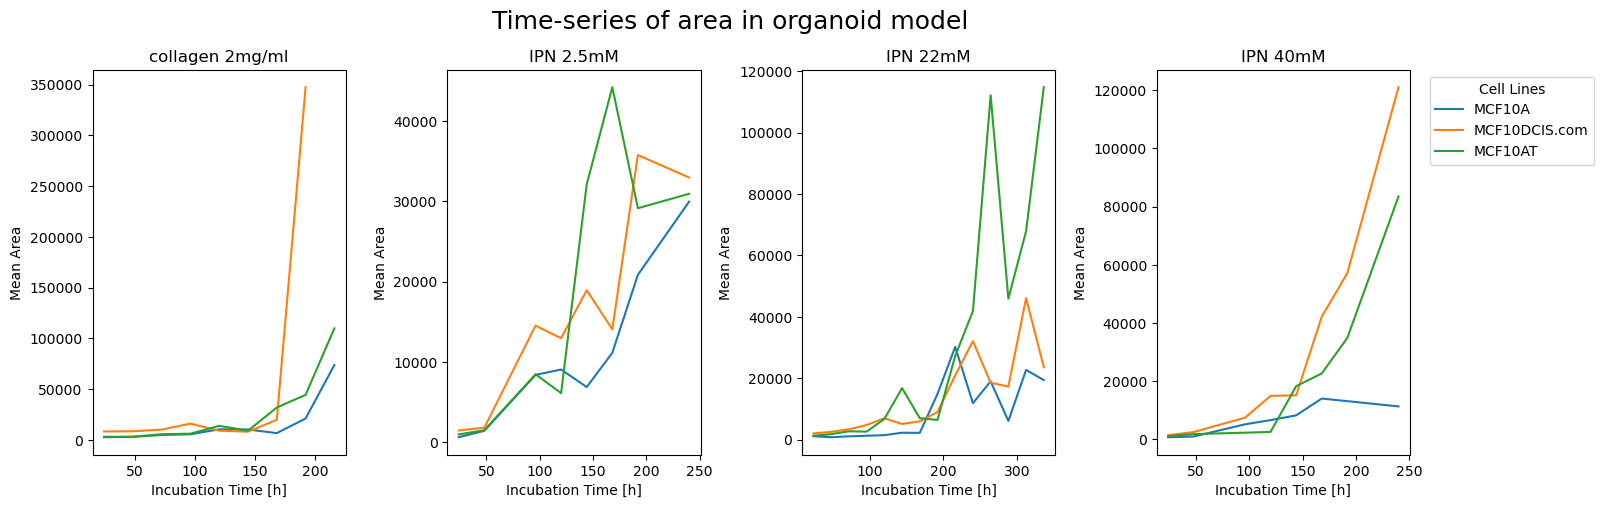

In [34]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.25)
fig.suptitle("Time-series of area in organoid model", fontsize=18, y=1)

Exp1_N.dropna(subset=['area'], inplace=True)

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[Exp1_N['material'] == unique_material]
    specific_df_grp = specific_df.groupby(['material','cell_line', 'incubation_time'])['area'].mean() #MultiIndexed series
    specific_df_grp_df = specific_df_grp.reset_index() #converting into df
    
    ax = axs[i]
    for cell_line in unique_lines:
            cell_line_data = specific_df_grp_df[specific_df_grp_df['cell_line'] == cell_line]
            ax.plot(cell_line_data['incubation_time'], cell_line_data['area'], label=cell_line)
    
    ax.set_xlabel('Incubation Time [h]')
    ax.set_ylabel('Mean Area')
    ax.set_title(unique_material)

ax.legend(title="Cell Lines", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot


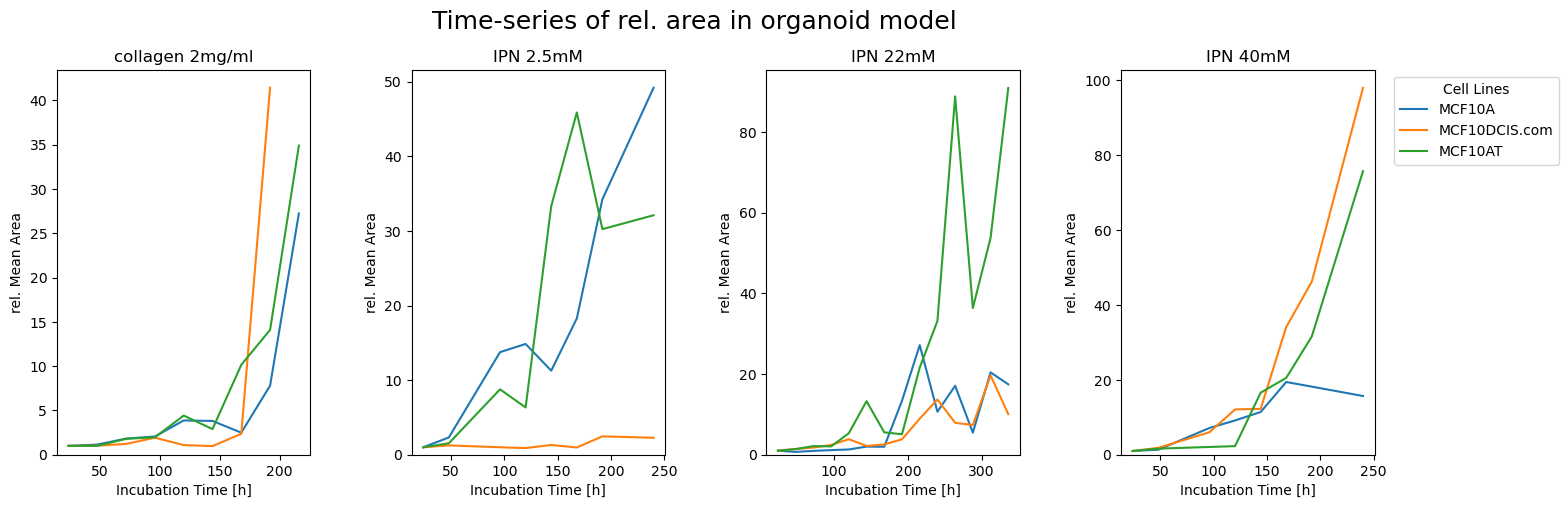

In [8]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.25)
fig.suptitle("Time-series of rel. area in organoid model", fontsize=18, y=1)

Exp1_N.dropna(subset=['area'], inplace=True)

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[Exp1_N['material'] == unique_material]
    specific_df_grp = specific_df.groupby(['material','cell_line', 'incubation_time'])['area_N'].mean() #MultiIndexed series
    specific_df_grp_df = specific_df_grp.reset_index() #converting into df
    
    ax = axs[i]
    for cell_line in unique_lines:
            cell_line_data = specific_df_grp_df[specific_df_grp_df['cell_line'] == cell_line]
            ax.plot(cell_line_data['incubation_time'], cell_line_data['area_N'], label=cell_line)
    
    ax.set_xlabel('Incubation Time [h]')
    ax.set_ylabel('rel. Mean Area')
    ax.set_ylim(0,)

    ax.set_title(unique_material)

ax.legend(title="Cell Lines", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot


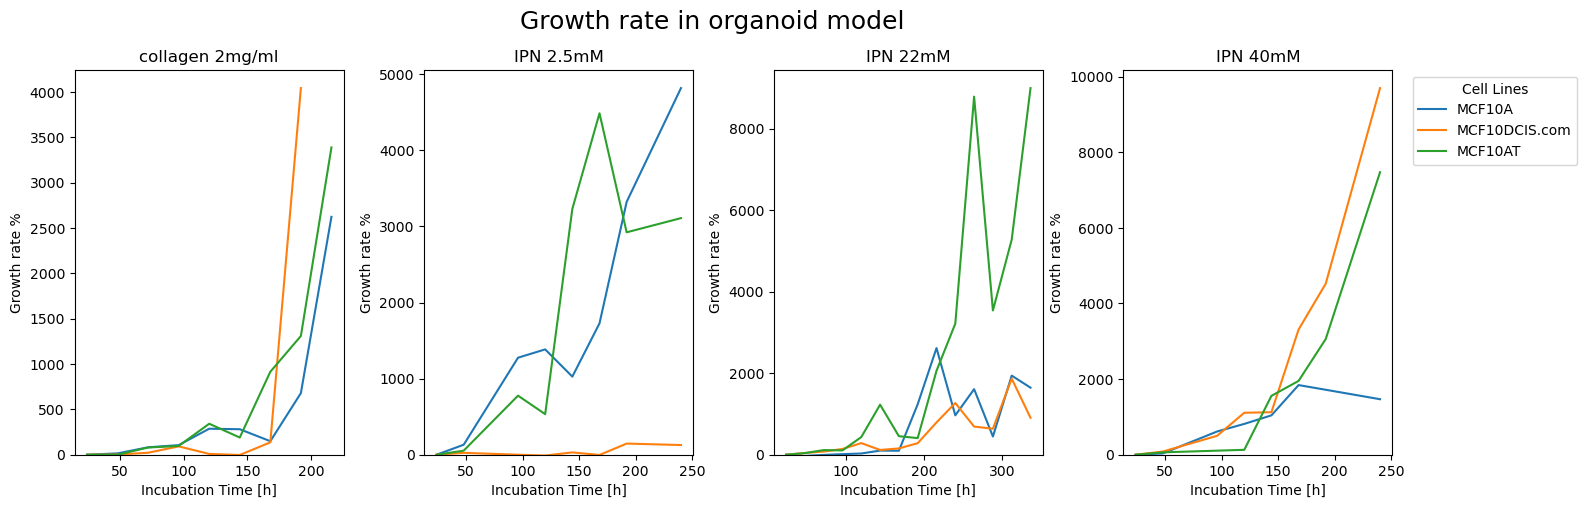

In [9]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.25)
fig.suptitle("Growth rate in organoid model", fontsize=18, y=1)

Exp1_N.dropna(subset=['area'], inplace=True)

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[Exp1_N['material'] == unique_material]
    specific_df_grp = specific_df.groupby(['material','cell_line', 'incubation_time'])['growth_rate_%'].mean() #MultiIndexed series
    specific_df_grp_df = specific_df_grp.reset_index() #converting into df
    

    ax = axs[i]
    for cell_line in unique_lines:
        cell_line_data = specific_df_grp_df[specific_df_grp_df['cell_line'] == cell_line]
        ax.plot(cell_line_data['incubation_time'], cell_line_data['growth_rate_%'], label=cell_line)
    
    ax.set_xlabel('Incubation Time [h]')
    ax.set_ylabel('Growth rate %')
    ax.set_title(unique_material)
    ax.set_ylim(0,)


ax.legend(title="Cell Lines", bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot



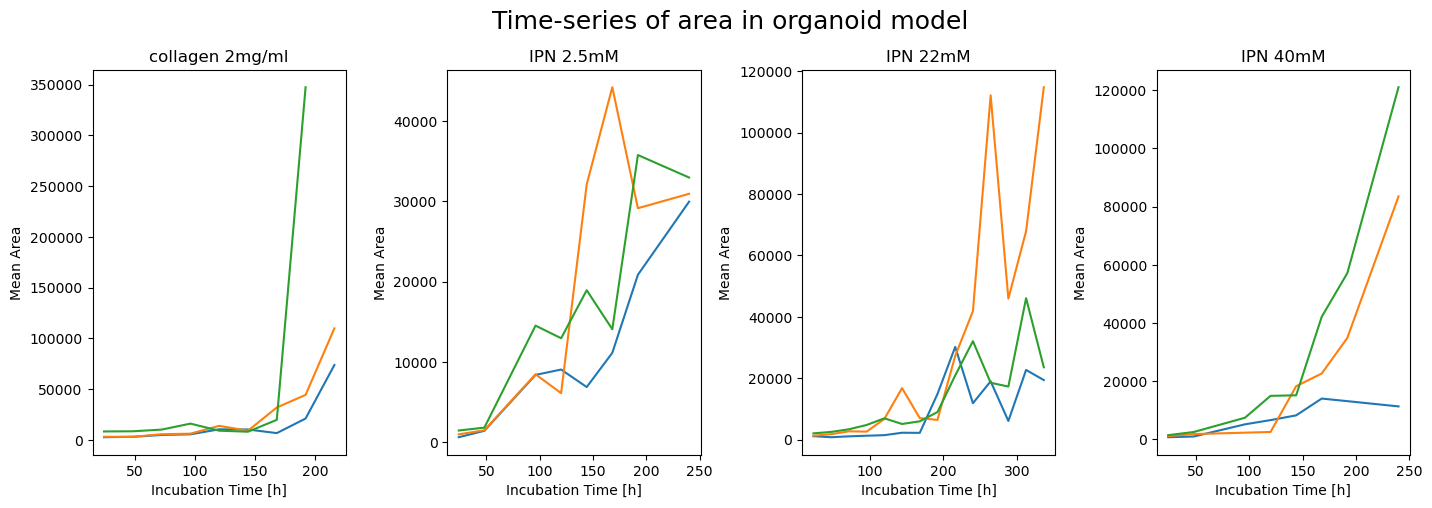

In [10]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.25)
fig.suptitle("Time-series of area in organoid model", fontsize=18, y=1)

Exp1_N.dropna(subset=['area'], inplace=True)

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[Exp1_N['material'] == unique_material]
    specific_df_grp = specific_df.groupby(['material','cell_line', 'incubation_time'])['area'].mean() #MultiIndexed series
    specific_df_grp_df = specific_df_grp.reset_index() #converting into df
    
    cell_lines = specific_df_grp_df['cell_line'].unique()

    ax = axs[i]
    for cell_line in cell_lines:
            cell_line_data = specific_df_grp_df[specific_df_grp_df['cell_line'] == cell_line]
            ax.plot(cell_line_data['incubation_time'], cell_line_data['area'], label=cell_line)
    
    ax.set_xlabel('Incubation Time [h]')
    ax.set_ylabel('Mean Area')
    ax.set_title(unique_material)

    #print(specific_df_grp_df)

In [18]:
print(Exp1_N.columns)


Index(['id', 'id_in_image', 'path', 'well_type', 'seeding_density', 'date',
       'cell_line', 'cell_line_no', 'incubation_time', 'image_id',
       'magnification', 'material', 'concentration', 'area', 'perimeter',
       'convex hull area', 'convex hull perimeter', 'convexity_perimeter',
       'convexity_area', 'compactness', 'aspect_ratio', 'mean_t0_area',
       'mean_t0_perimeter', 'mean_t0_convex_hull_area',
       'mean_t0_convex_hull_perimeter', 'mean_t0_convexity_perimeter',
       'mean_t0_convexity_area', 'mean_t0_compactness', 'mean_t0_aspect_ratio',
       'growth_rate_%', 'area_N', 'compactness_N', 'aspect_ratio_N',
       'convexity_perimeter_N', 'convexity_area_N'],
      dtype='object')


C:\Users\srboval1\AppData\Local\Temp\ipykernel_12464\2867602823.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['area'], ax=ax, log_scale=True,


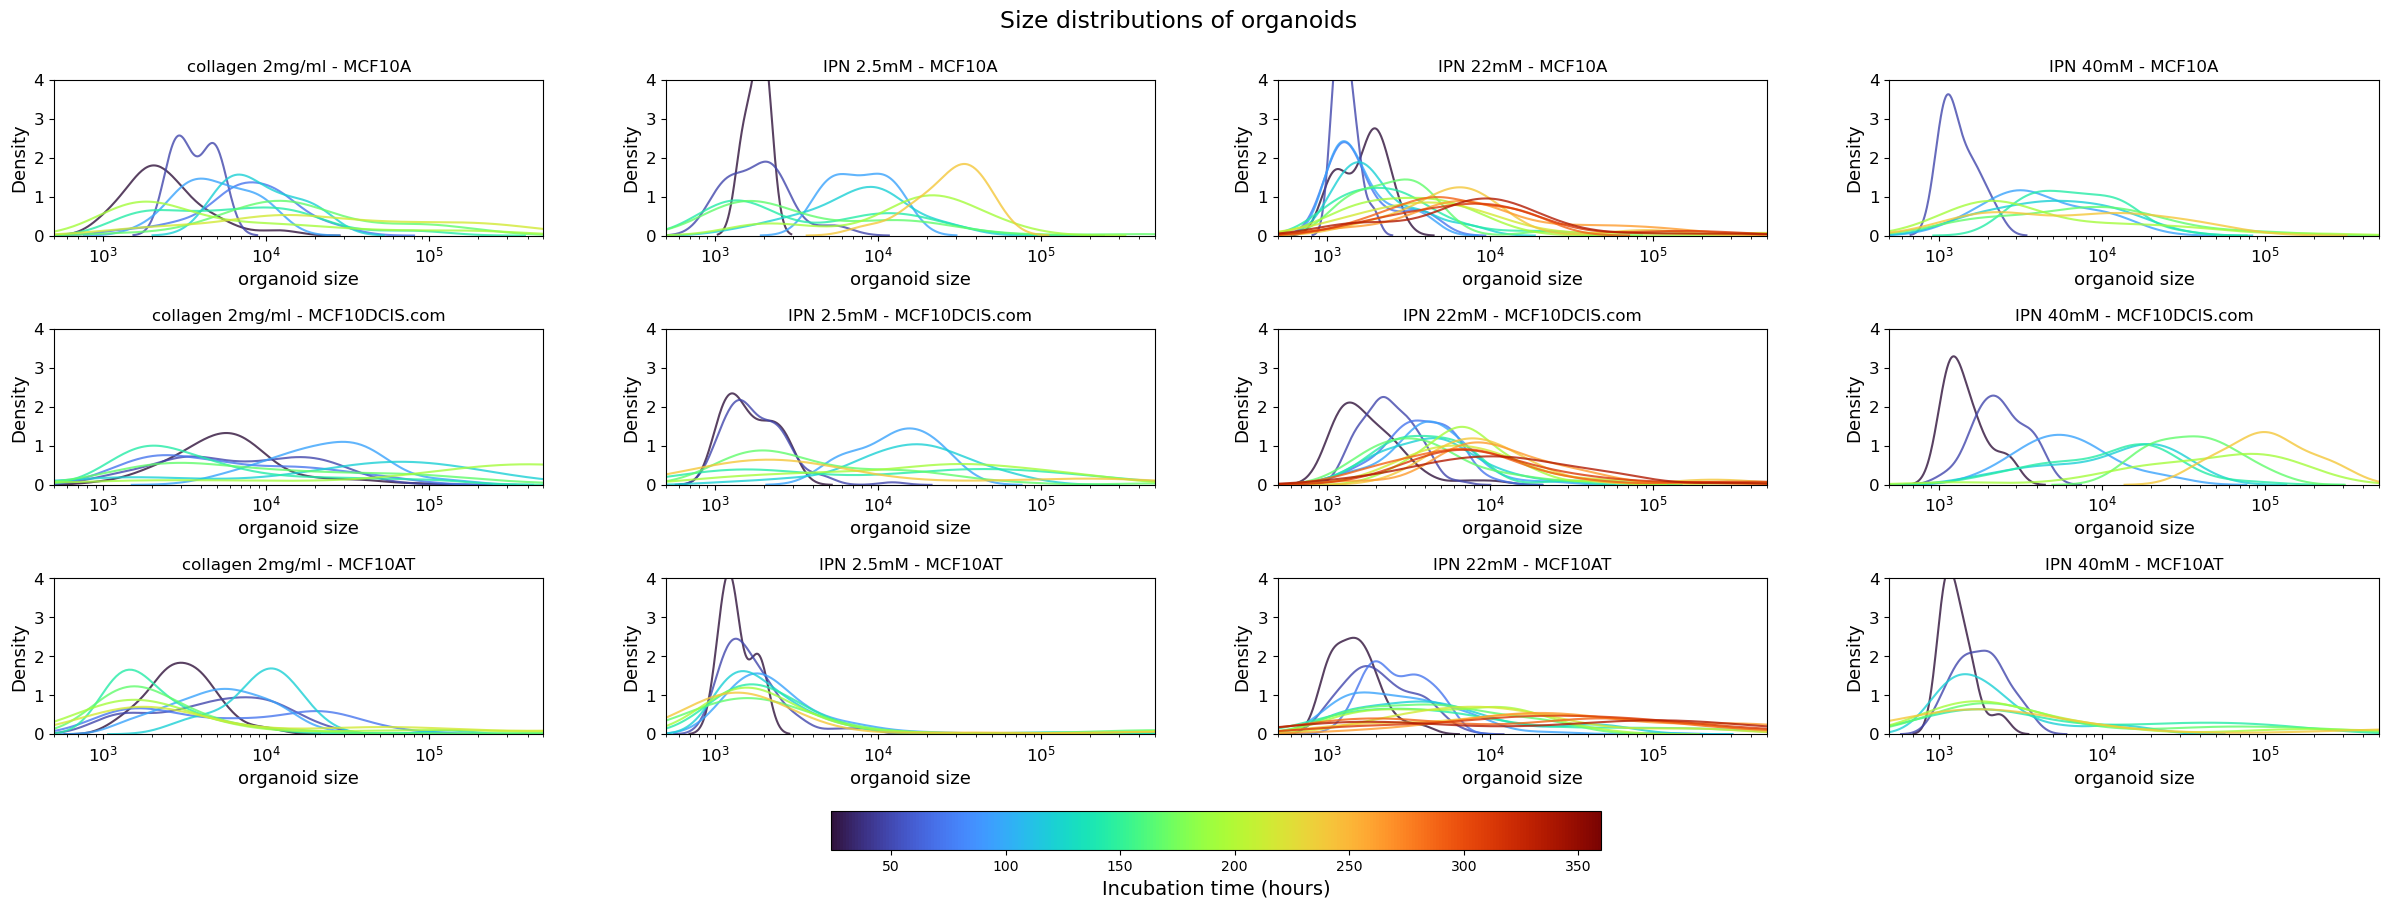

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Size distributions of organoids", fontsize=17, y=0.95)

timestamp = 360     
cuttof_area = 1000  

# min and max for the color bar normalization
min_time, max_time = Exp1_N['incubation_time'].min(), timestamp

# colormap and normalize based on the incubation_time range
norm = mcolors.Normalize(vmin=min_time, vmax=max_time)
colormap = plt.cm.turbo

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[(Exp1_N['material'] == unique_material) & (Exp1_N['area'] > cuttof_area)]
    for j, unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line) & (specific_df['incubation_time'] < timestamp)]
        ax = axs[j, i]
        
        for time in sorted(specific_specific_df['incubation_time'].unique()):
            subset = specific_specific_df[specific_specific_df['incubation_time'] == time]
            sns.kdeplot(subset['area'], ax=ax, log_scale=True, 
                        color=colormap(norm(time)), label=f"{time}h", alpha=0.8)
        
        ax.set_xlabel('organoid size',fontsize=13)
        ax.set_ylabel('Density',fontsize=13)
        ax.set_title(f'{unique_material} - {unique_line}')
        ax.set_xlim(500, 500000)
        ax.set_ylim(0, 4)
        ax.tick_params(axis='both', which='major', labelsize=12)

# color bar for the incubation time gradient
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Incubation time (hours)", fontsize= 14)

plt.show()


In [13]:
def looping(data, unique_materials, unique_lines, title, function,variable,xlim=1, ylim=1):
    
    fig.suptitle(title, fontsize=25, y=1)

    for i, unique_material in enumerate(unique_materials):
        specific_data = data[data['material'] == unique_material]
        for j, unique_line in enumerate(unique_lines):
            specific_specific_data = specific_data[specific_data['cell_line'] == unique_line]
            
            function(specific_specific_data, i, j, unique_material, unique_line,variable,xlim, ylim)

Data & mean values

In [14]:
def plotting(data ,i, j, unique_material, unique_line,variable,xlim,ylim):
    ax = axs[j,i]
    sns.stripplot(x='incubation_time', y=variable, data=data, 
               color=color[j], label=unique_line, ax=ax, jitter=True)
    mean_values = data.groupby('incubation_time')[variable].mean().reset_index()
# Create the mean plot using pointplot
    sns.pointplot(x='incubation_time', y=variable, data=data,
               estimator='mean', color='orange', label='Mean', 
               ax=ax, markers='_', linewidth=2)    
    ax.get_legend().remove()
    ax.set_xlabel('Incubation time [hours]', fontsize=15)  
    #ax.set_yscale('log')
    ax.set_ylabel(variable, fontsize=15)  
    ax.set_title(f'{unique_material}-{unique_line}', fontsize=18)
    ax.set_ylim(xlim, ylim)
    #x_ticks = [24,48,72,96,120,144,168,192, 214, 240]


    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)


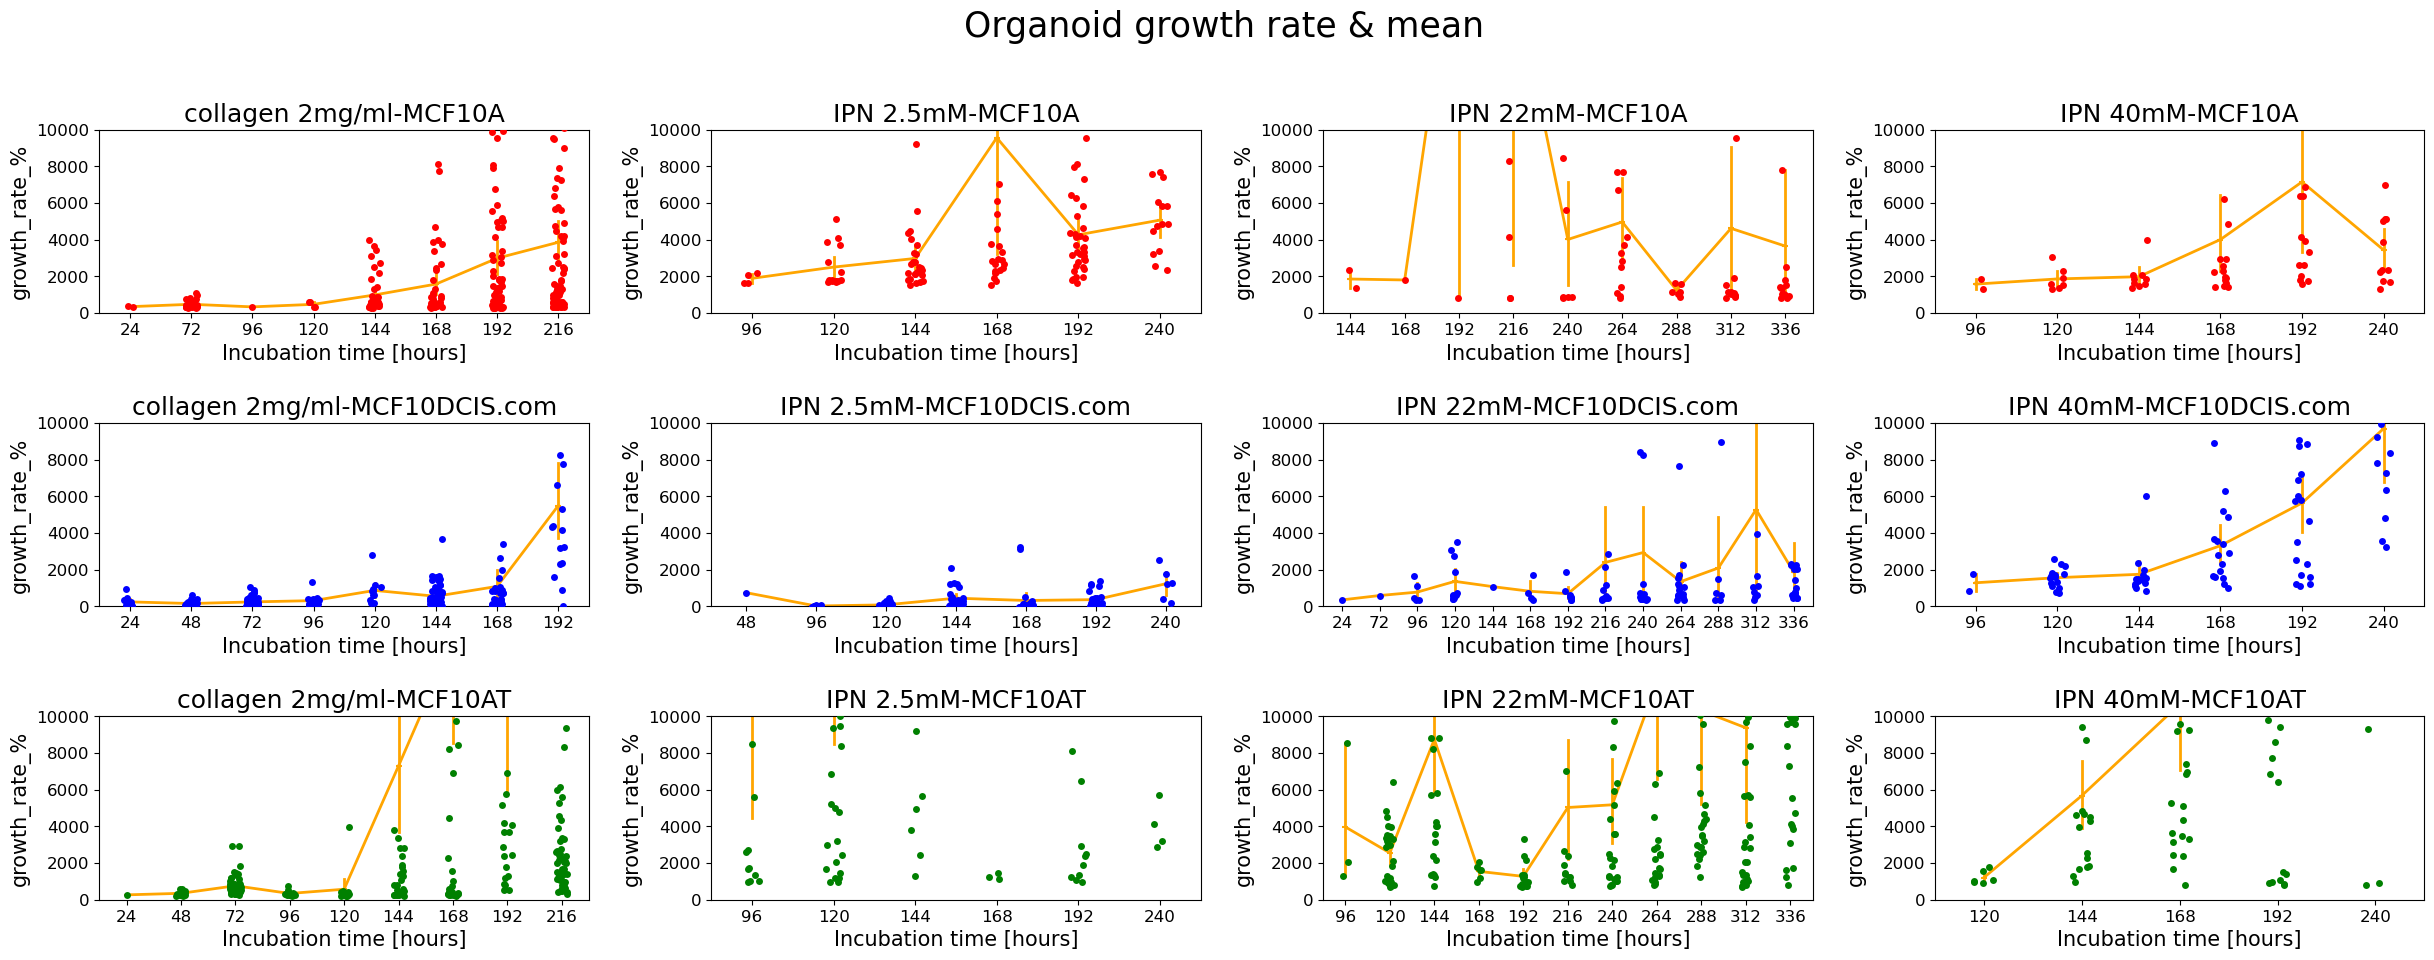

In [24]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Organoid growth rate & mean', plotting, 'growth_rate_%',0, 10000)
plt.savefig(path +'/results/Organoid_area.png',dpi=300)


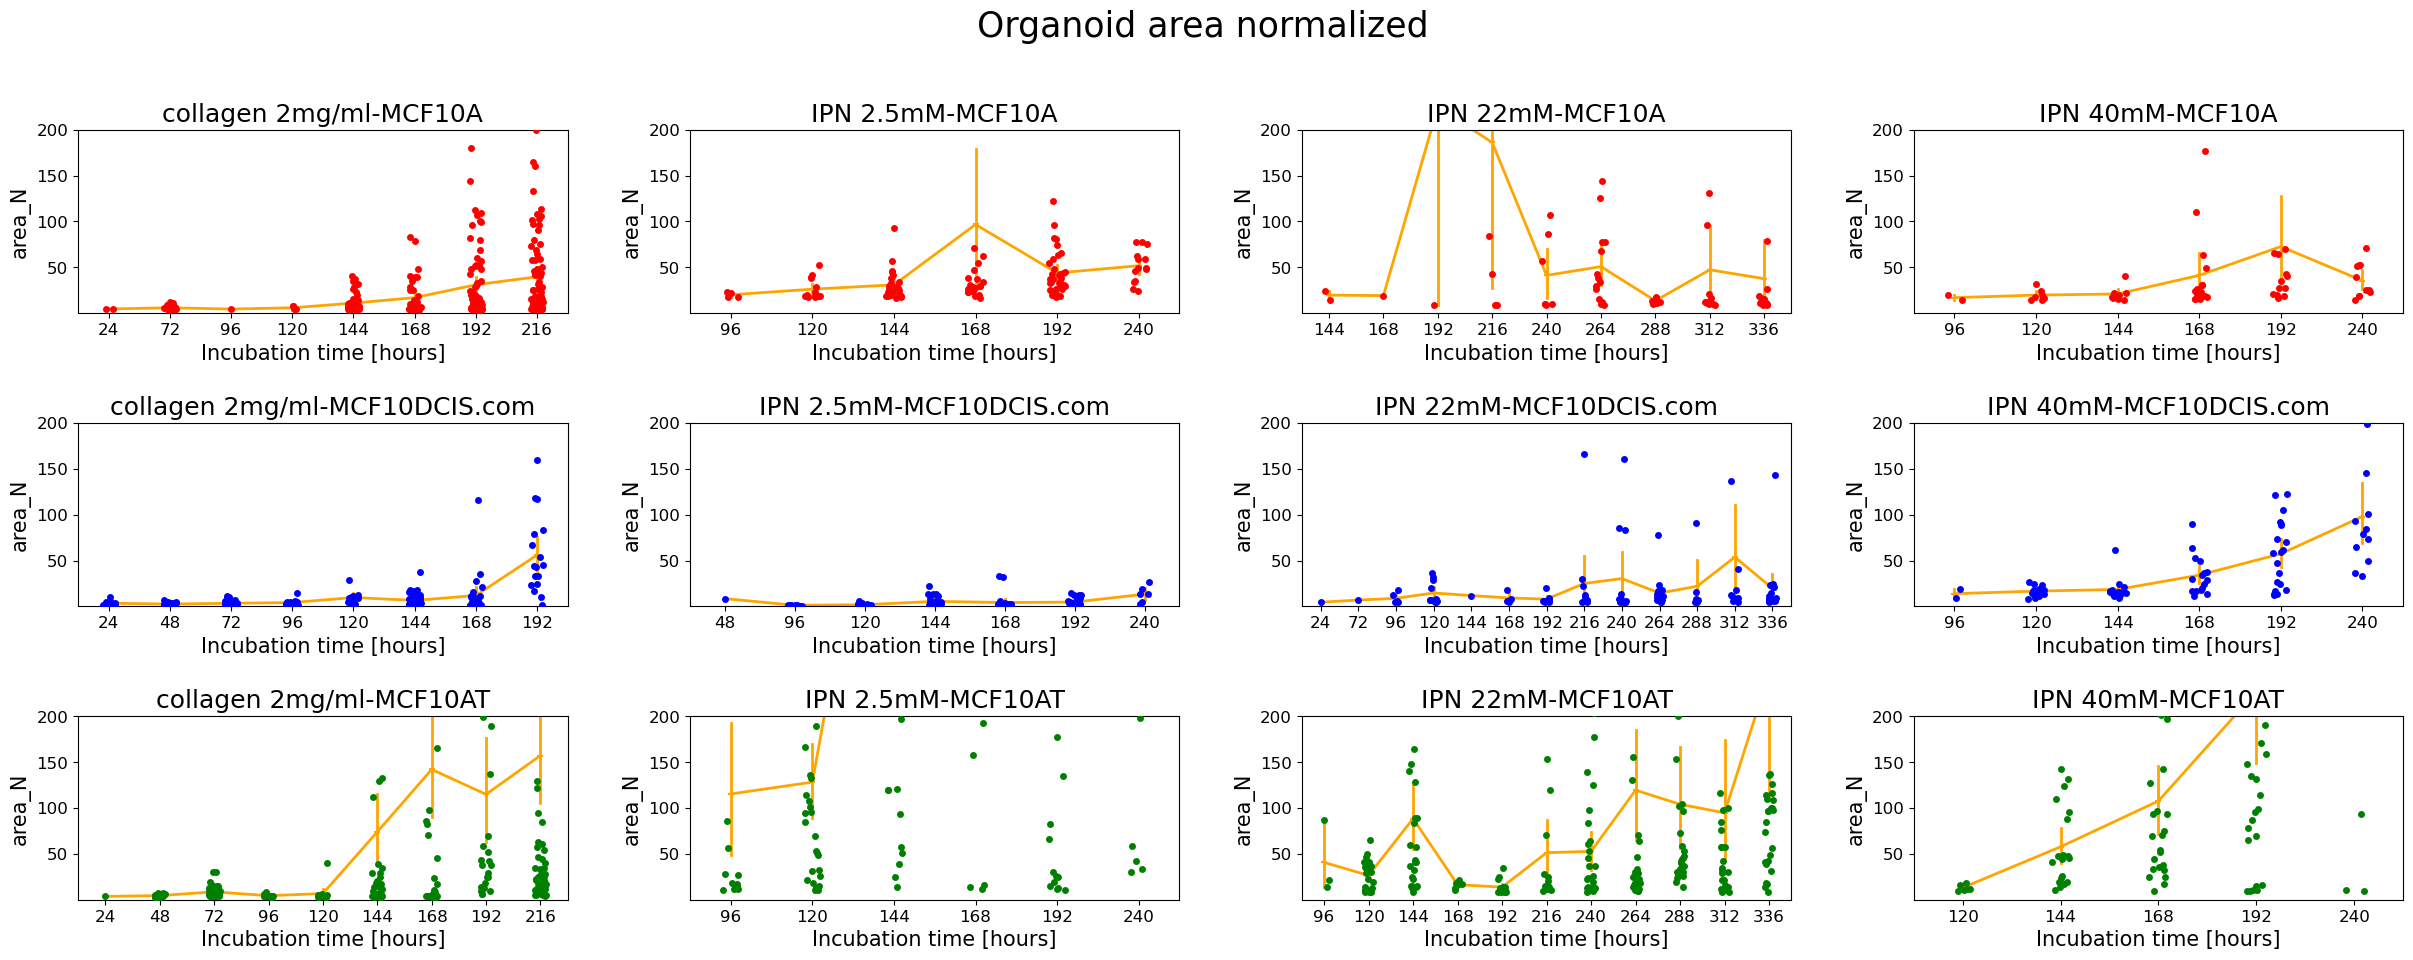

In [16]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Organoid area normalized', plotting, 'area_N',0.01, 200)
plt.savefig(path +'/results/Organoid_area_N.png',dpi=300)

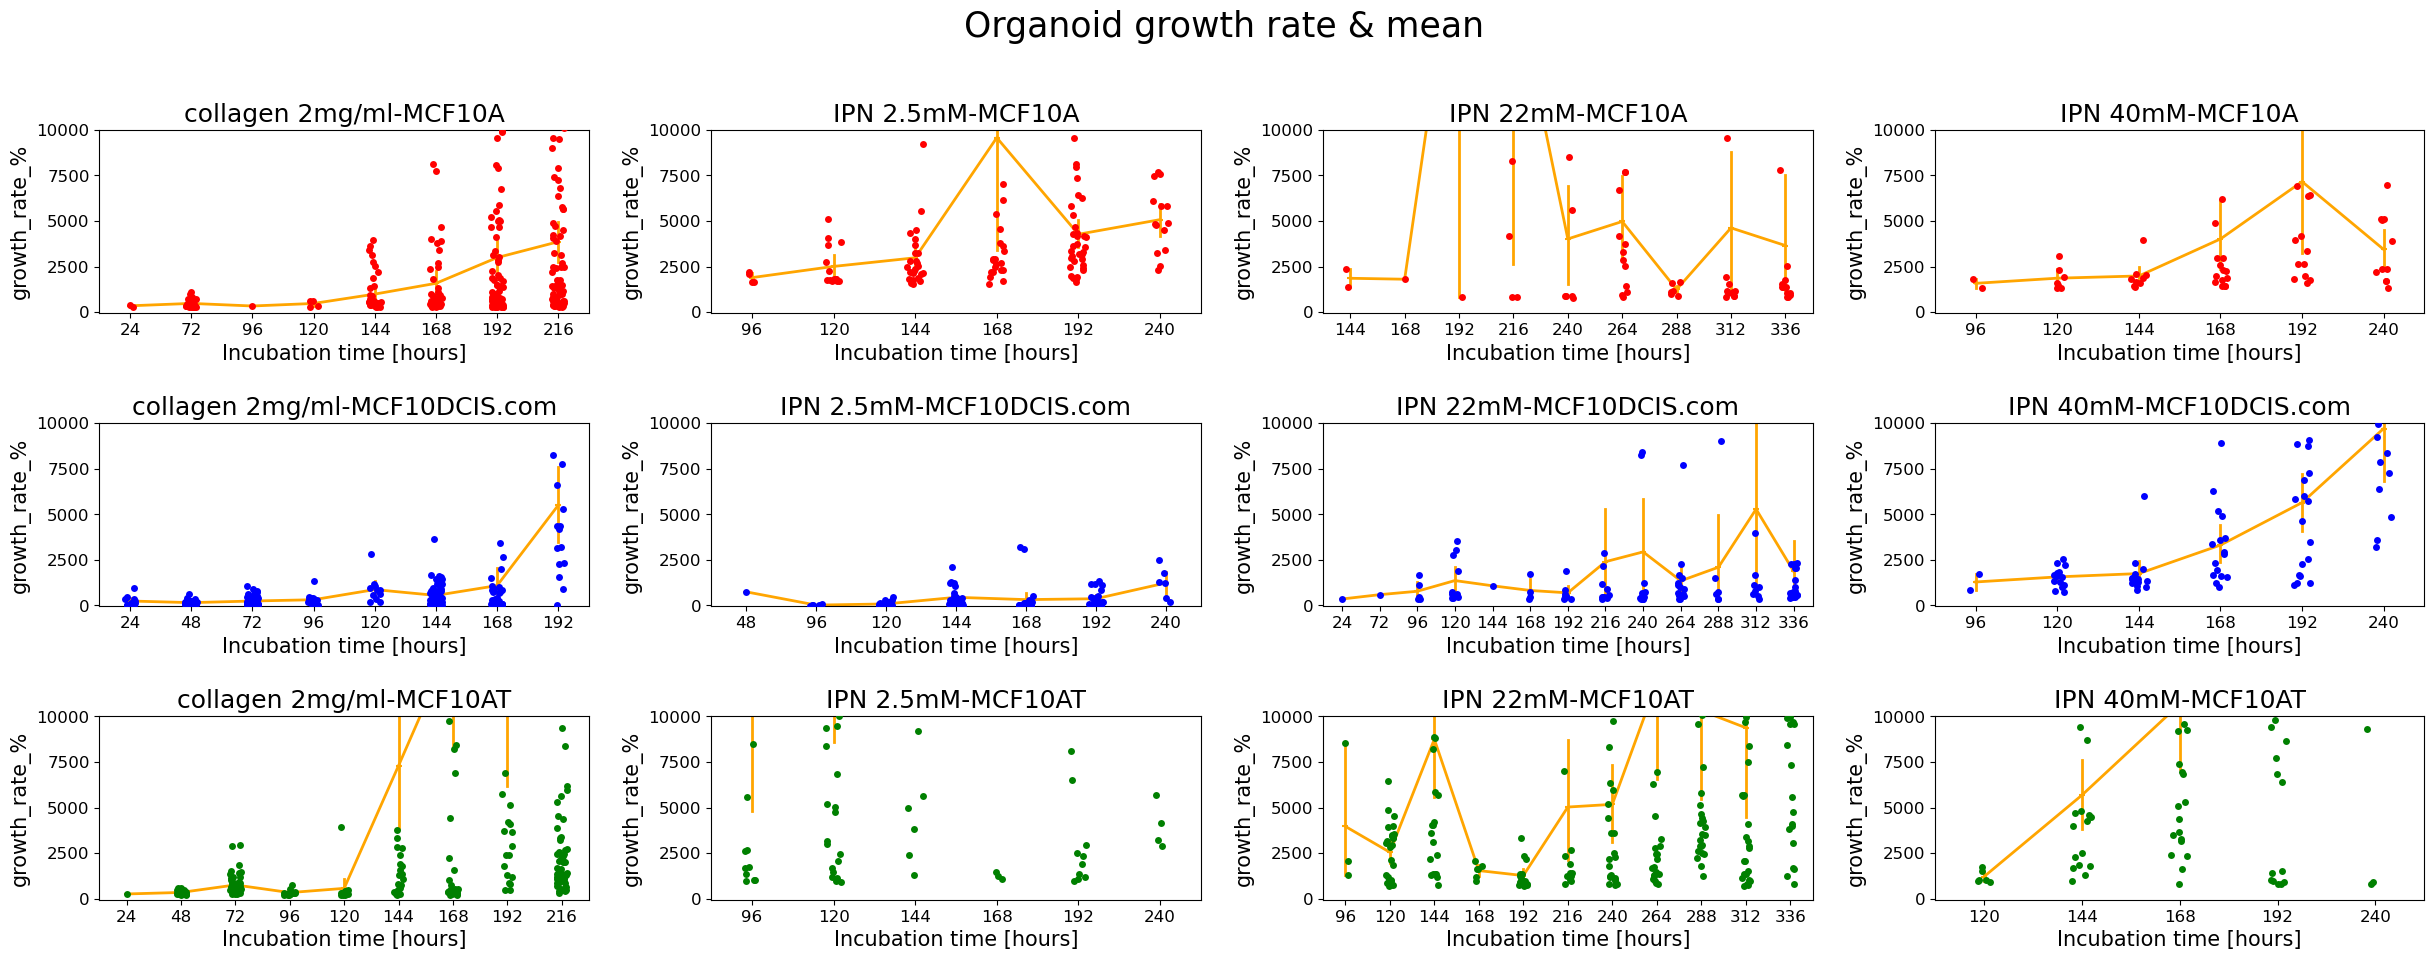

In [73]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Organoid growth rate & mean', plotting, 'growth_rate_%',-50, 10000)
plt.savefig(path +'/results/Organoid_growth_rate.png',dpi=300)


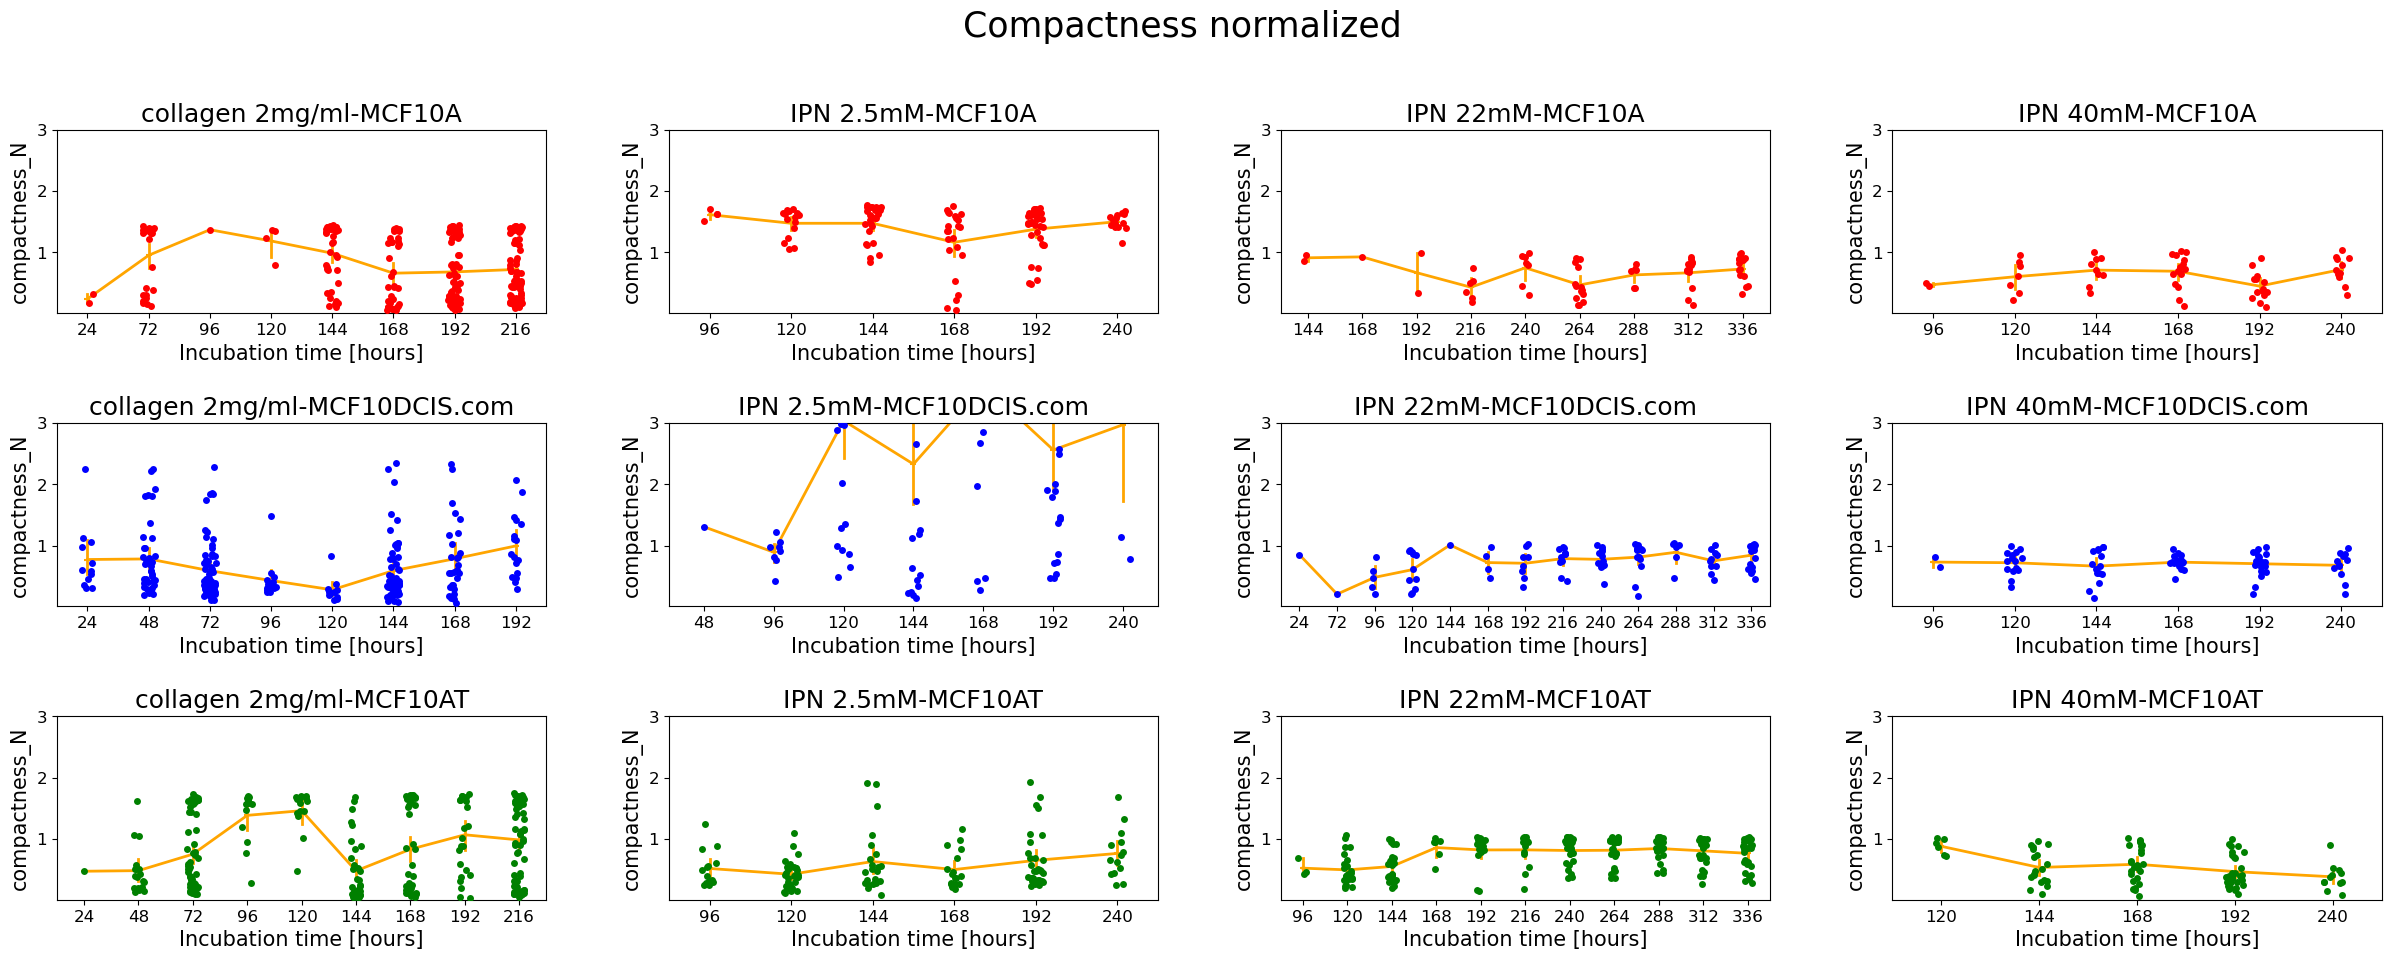

In [74]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Compactness normalized', plotting,'compactness_N',0.01,3)
plt.savefig(path +'/results/Compactness_area_N.png',dpi=300)

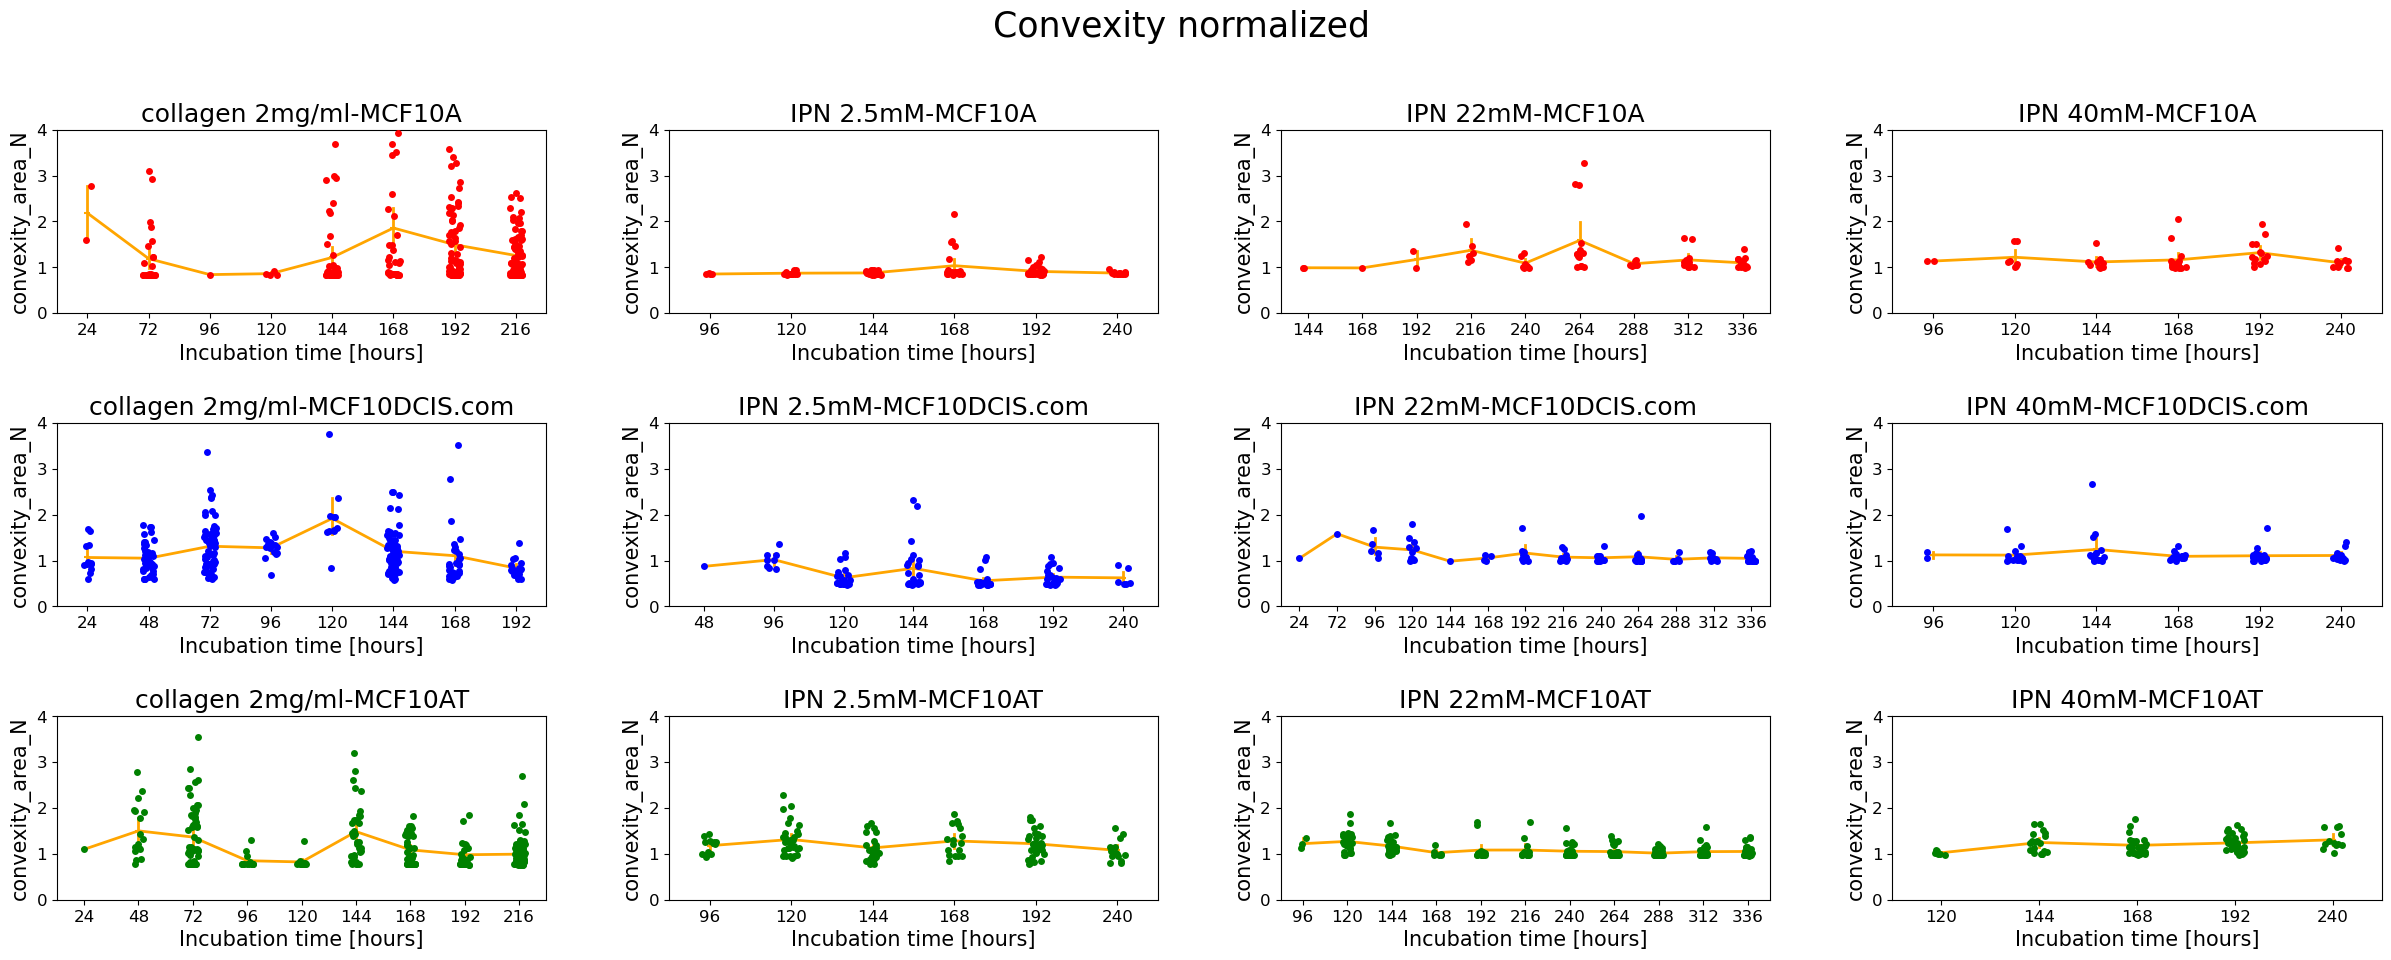

In [75]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Convexity normalized', plotting,'convexity_area_N',0,4)
plt.savefig(path +'/results/Compactness_areaN.png',dpi=300)

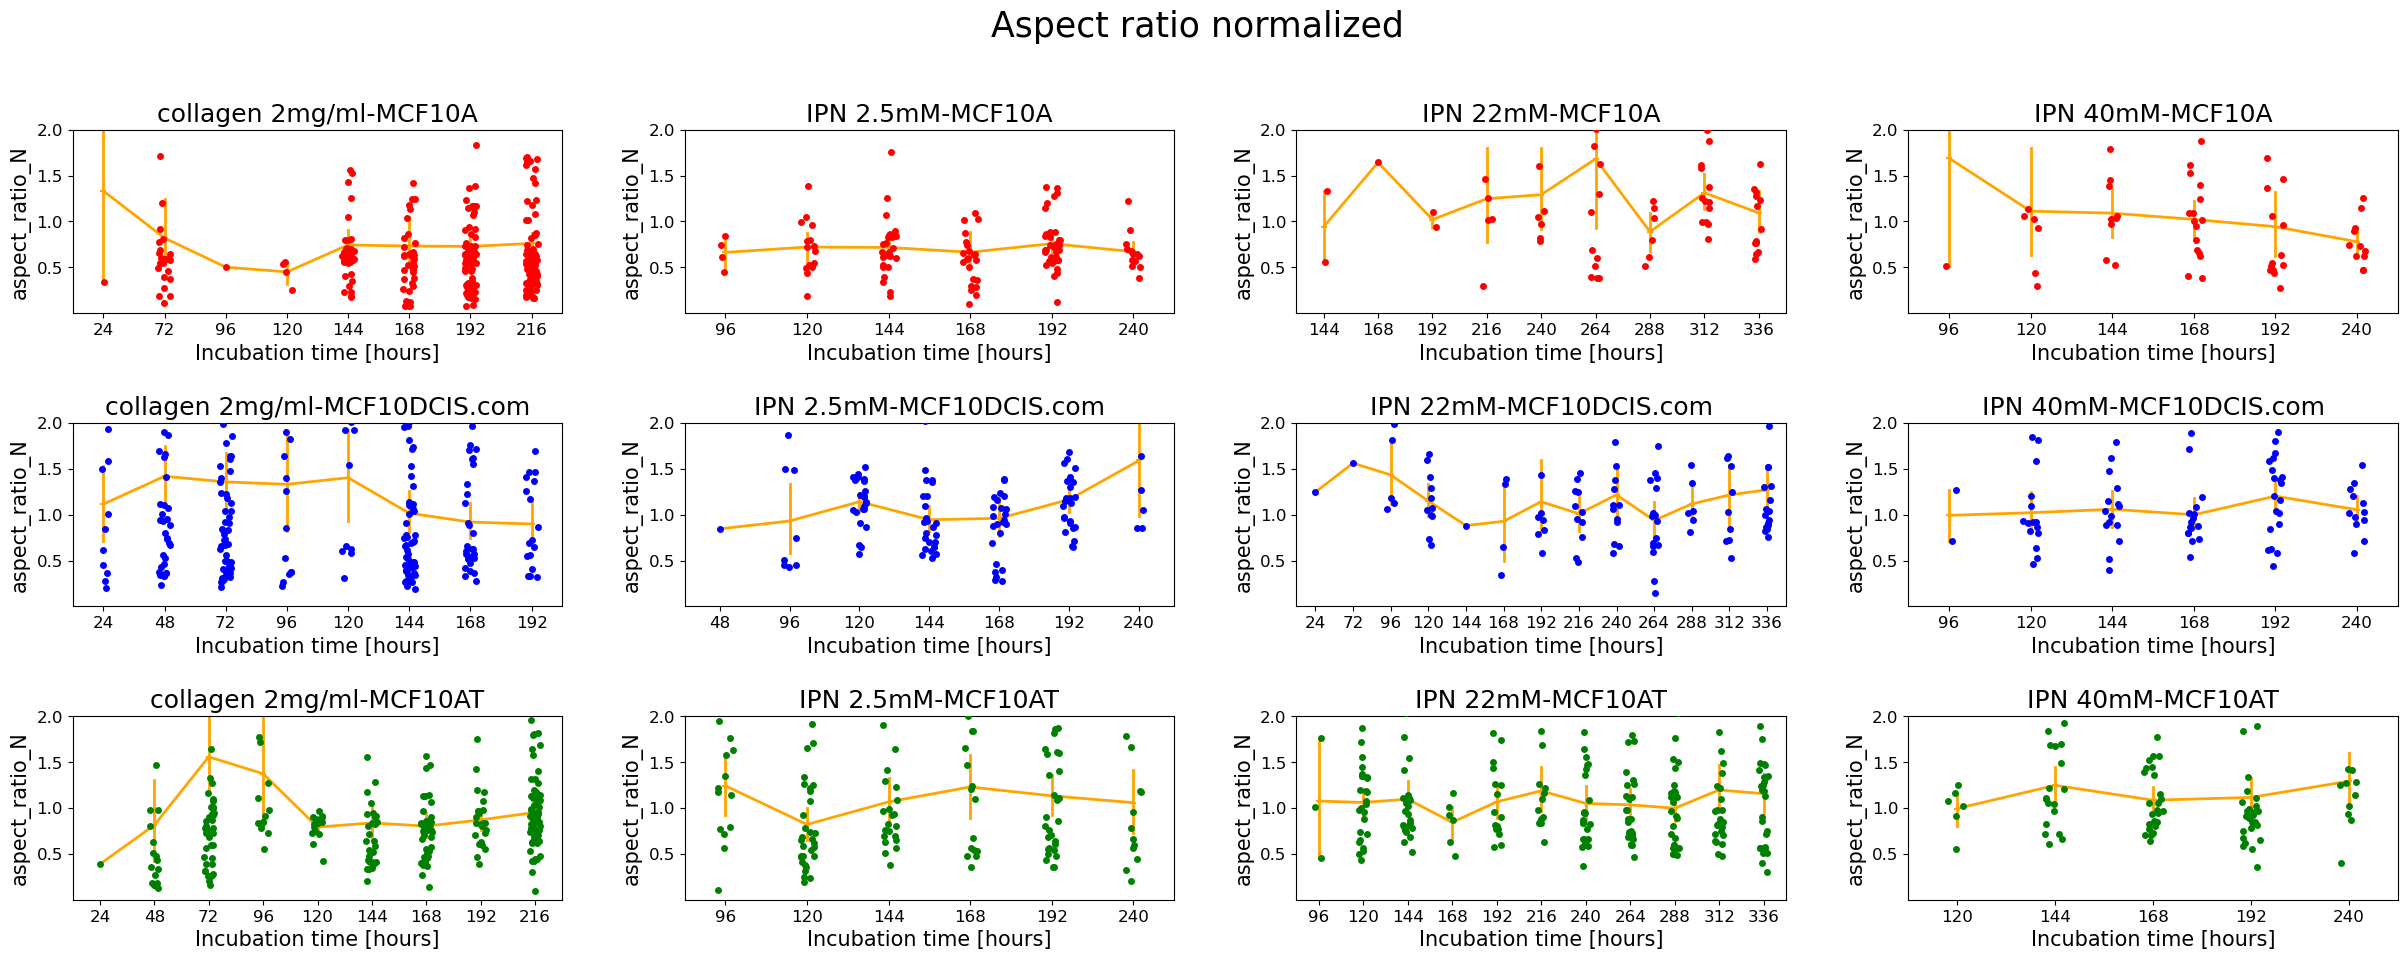

In [76]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Aspect ratio normalized', plotting,'aspect_ratio_N',0.001, 2)
plt.savefig(path +'/results/Compactness_areaN.png',dpi=300)

Fitting models to data

In [82]:
def gompertz(t, a, b, c):
    """Gompertz function definition."""
    return a * np.exp(-b * np.exp(-c * t))

def gompertz_fit(data, i, j, unique_material, unique_line,variable,xlim=1, ylim=1):
    # Initial guess for parameters [a, b, c]
    a=data['area_N'].max()+1000
    est_par = [a, 0.8, 10]  
    
    # Fit the Gompertz function to the data
    params, _ = curve_fit(gompertz, data['incubation_time'], data[variable], p0=est_par)
    
    # Extract fitted parameters
    a_fit, b_fit, c_fit = params

    # Generate values for the fitted curve
    xrange = np.linspace(data['incubation_time'].min(), data['incubation_time'].max(), 100) 
    fitted_values = gompertz(xrange, a_fit, b_fit, c_fit)   

    # Calculate residuals and standard error
    residuals = data[variable] - gompertz(data['incubation_time'], a_fit, b_fit, c_fit)
    std_error = np.std(residuals)
    
    # Call your plotting function with the fitted values and parameters
    plotting_fits(xrange, fitted_values, std_error, i, j, unique_material, unique_line,xlim,ylim)

def polynomial_fit(data, i, j, unique_material, unique_line,variable,xlim=1,ylim=1):
    # Fit a polynomial (linear in this case)
    mymodel = np.poly1d(np.polyfit(data['incubation_time'], data[variable], 1))
    xrange = np.linspace(data['incubation_time'].min(), data['incubation_time'].max(), 100)
    fitted_values = mymodel(xrange)

    # Calculate residuals and standard error
    residuals = data[variable] - mymodel(data['incubation_time'])
    std_error = np.std(residuals)

    # Call your plotting function
    plotting_fits(xrange, fitted_values, std_error, i, j, unique_material, unique_line,xlim, ylim)

def plotting_fits(x_range, fitted_line_values, std_error, i, j, unique_material, unique_line,xlim=1,ylim=1):
    ax = axs[i]
    ax.plot(x_range, fitted_line_values, color=color[j], label=unique_line)  # Use fitted values for plotting
    ax.fill_between(x_range, fitted_line_values - std_error, fitted_line_values + std_error, color=color[j], alpha=0.3)
    ax.set_xlabel('Incubation time [hours]', fontsize=15)  
    ax.set_yscale('log')
    ax.set_ylabel('Area', fontsize=15)  
    ax.set_title(f'{unique_material}', fontsize=18)
    #x.set_xlim(xlim, ylim)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)

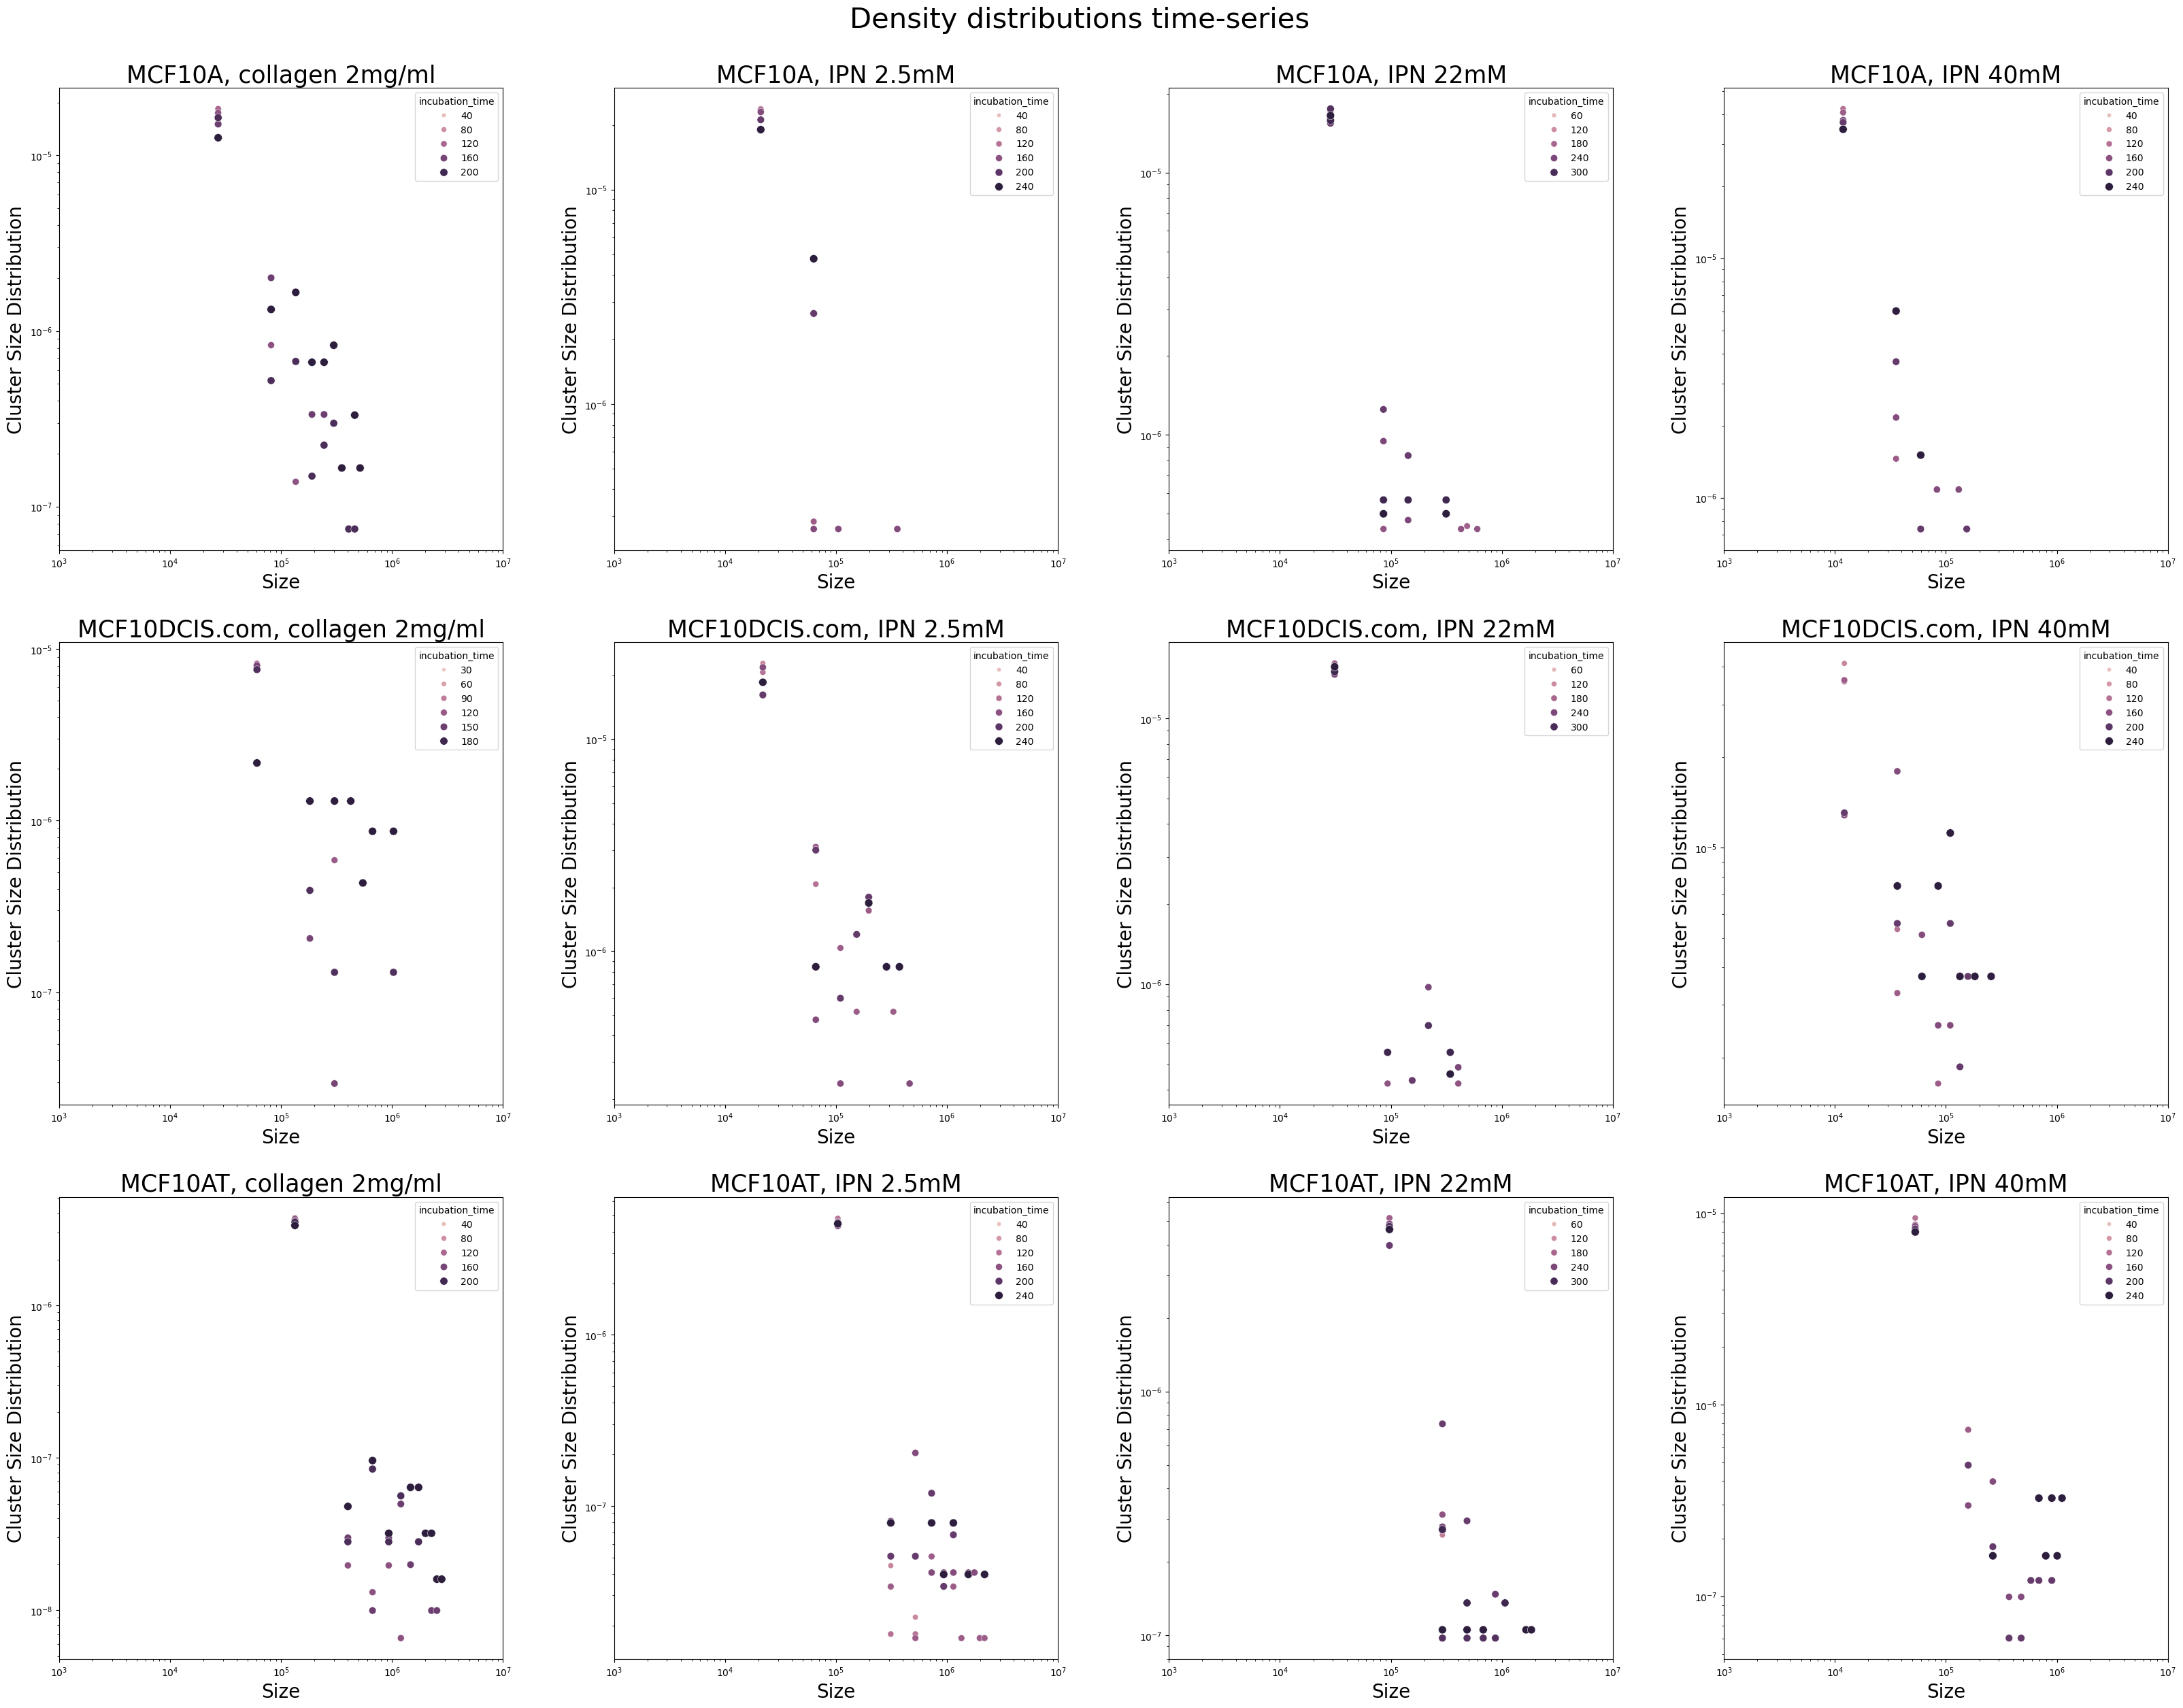

In [78]:

fig, axs = plt.subplots(3, len(unique_materials), figsize=(40, 30))
plt.subplots_adjust(wspace=0.25, hspace=0.2)
fig.suptitle("Density distributions time-series", fontsize=30,y=0.92)

s= Exp1_N[ (Exp1_N['area'] > 1000)]

for i, unique_material in enumerate(unique_materials):
    specific_data = s[s['material'] == unique_material]
    for j, unique_line in enumerate(unique_lines):
        ax = axs[j, i]
        specific_specific_data = specific_data[specific_data['cell_line'] == unique_line]
        bin_edges = np.linspace(int(min(specific_specific_data['area_N'])), int(max(specific_specific_data['area'])), num=12)
        
        # Calculating histograms for each timestamp
        densities = specific_specific_data.groupby('incubation_time')['area'].apply(
            lambda x: np.histogram(x, bins=bin_edges, density=True)[0]
        )
        
        # DataFrame for plotting
        density_df = pd.DataFrame(densities.tolist(), index=densities.index).reset_index()
        density_df.columns = ['incubation_time'] + [f'density_{i}' for i in range(density_df.shape[1] - 1)]
        
        # Add bin centers for plotting
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        density_df = density_df.melt(id_vars='incubation_time', var_name='bin', value_name='density')
        density_df['bin'] = density_df['bin'].str.extract(r'(\d+)').astype(int)
        density_df['bin_center'] = bin_centers[density_df['bin']]
        
        # Plotting
        sns.scatterplot(data=density_df, x='bin_center', y='density', hue='incubation_time', size='incubation_time', ax=ax)
        
        # Set labels and title
        ax.set_xlabel("Size", fontsize=20)
        ax.set_ylabel("Cluster Size Distribution", fontsize=20)
        ax.set_title(f"{unique_line}, {unique_material}", fontsize=25)

        # Calculate Q1, Q3, and IQR
        #
        Q1 = density_df['density'].quantile(0.25)
        Q3 = density_df['density'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Set y-axis limit at Q3 + 1.5 * IQR
        y_limit = Q3 + 1.5 * IQR
        #print(density_df['density'].describe())
        min_y_limit = max(0, y_limit)  # Ensures y_limit is not less than 0
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(1000, 10000000)

           
    

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 50000.

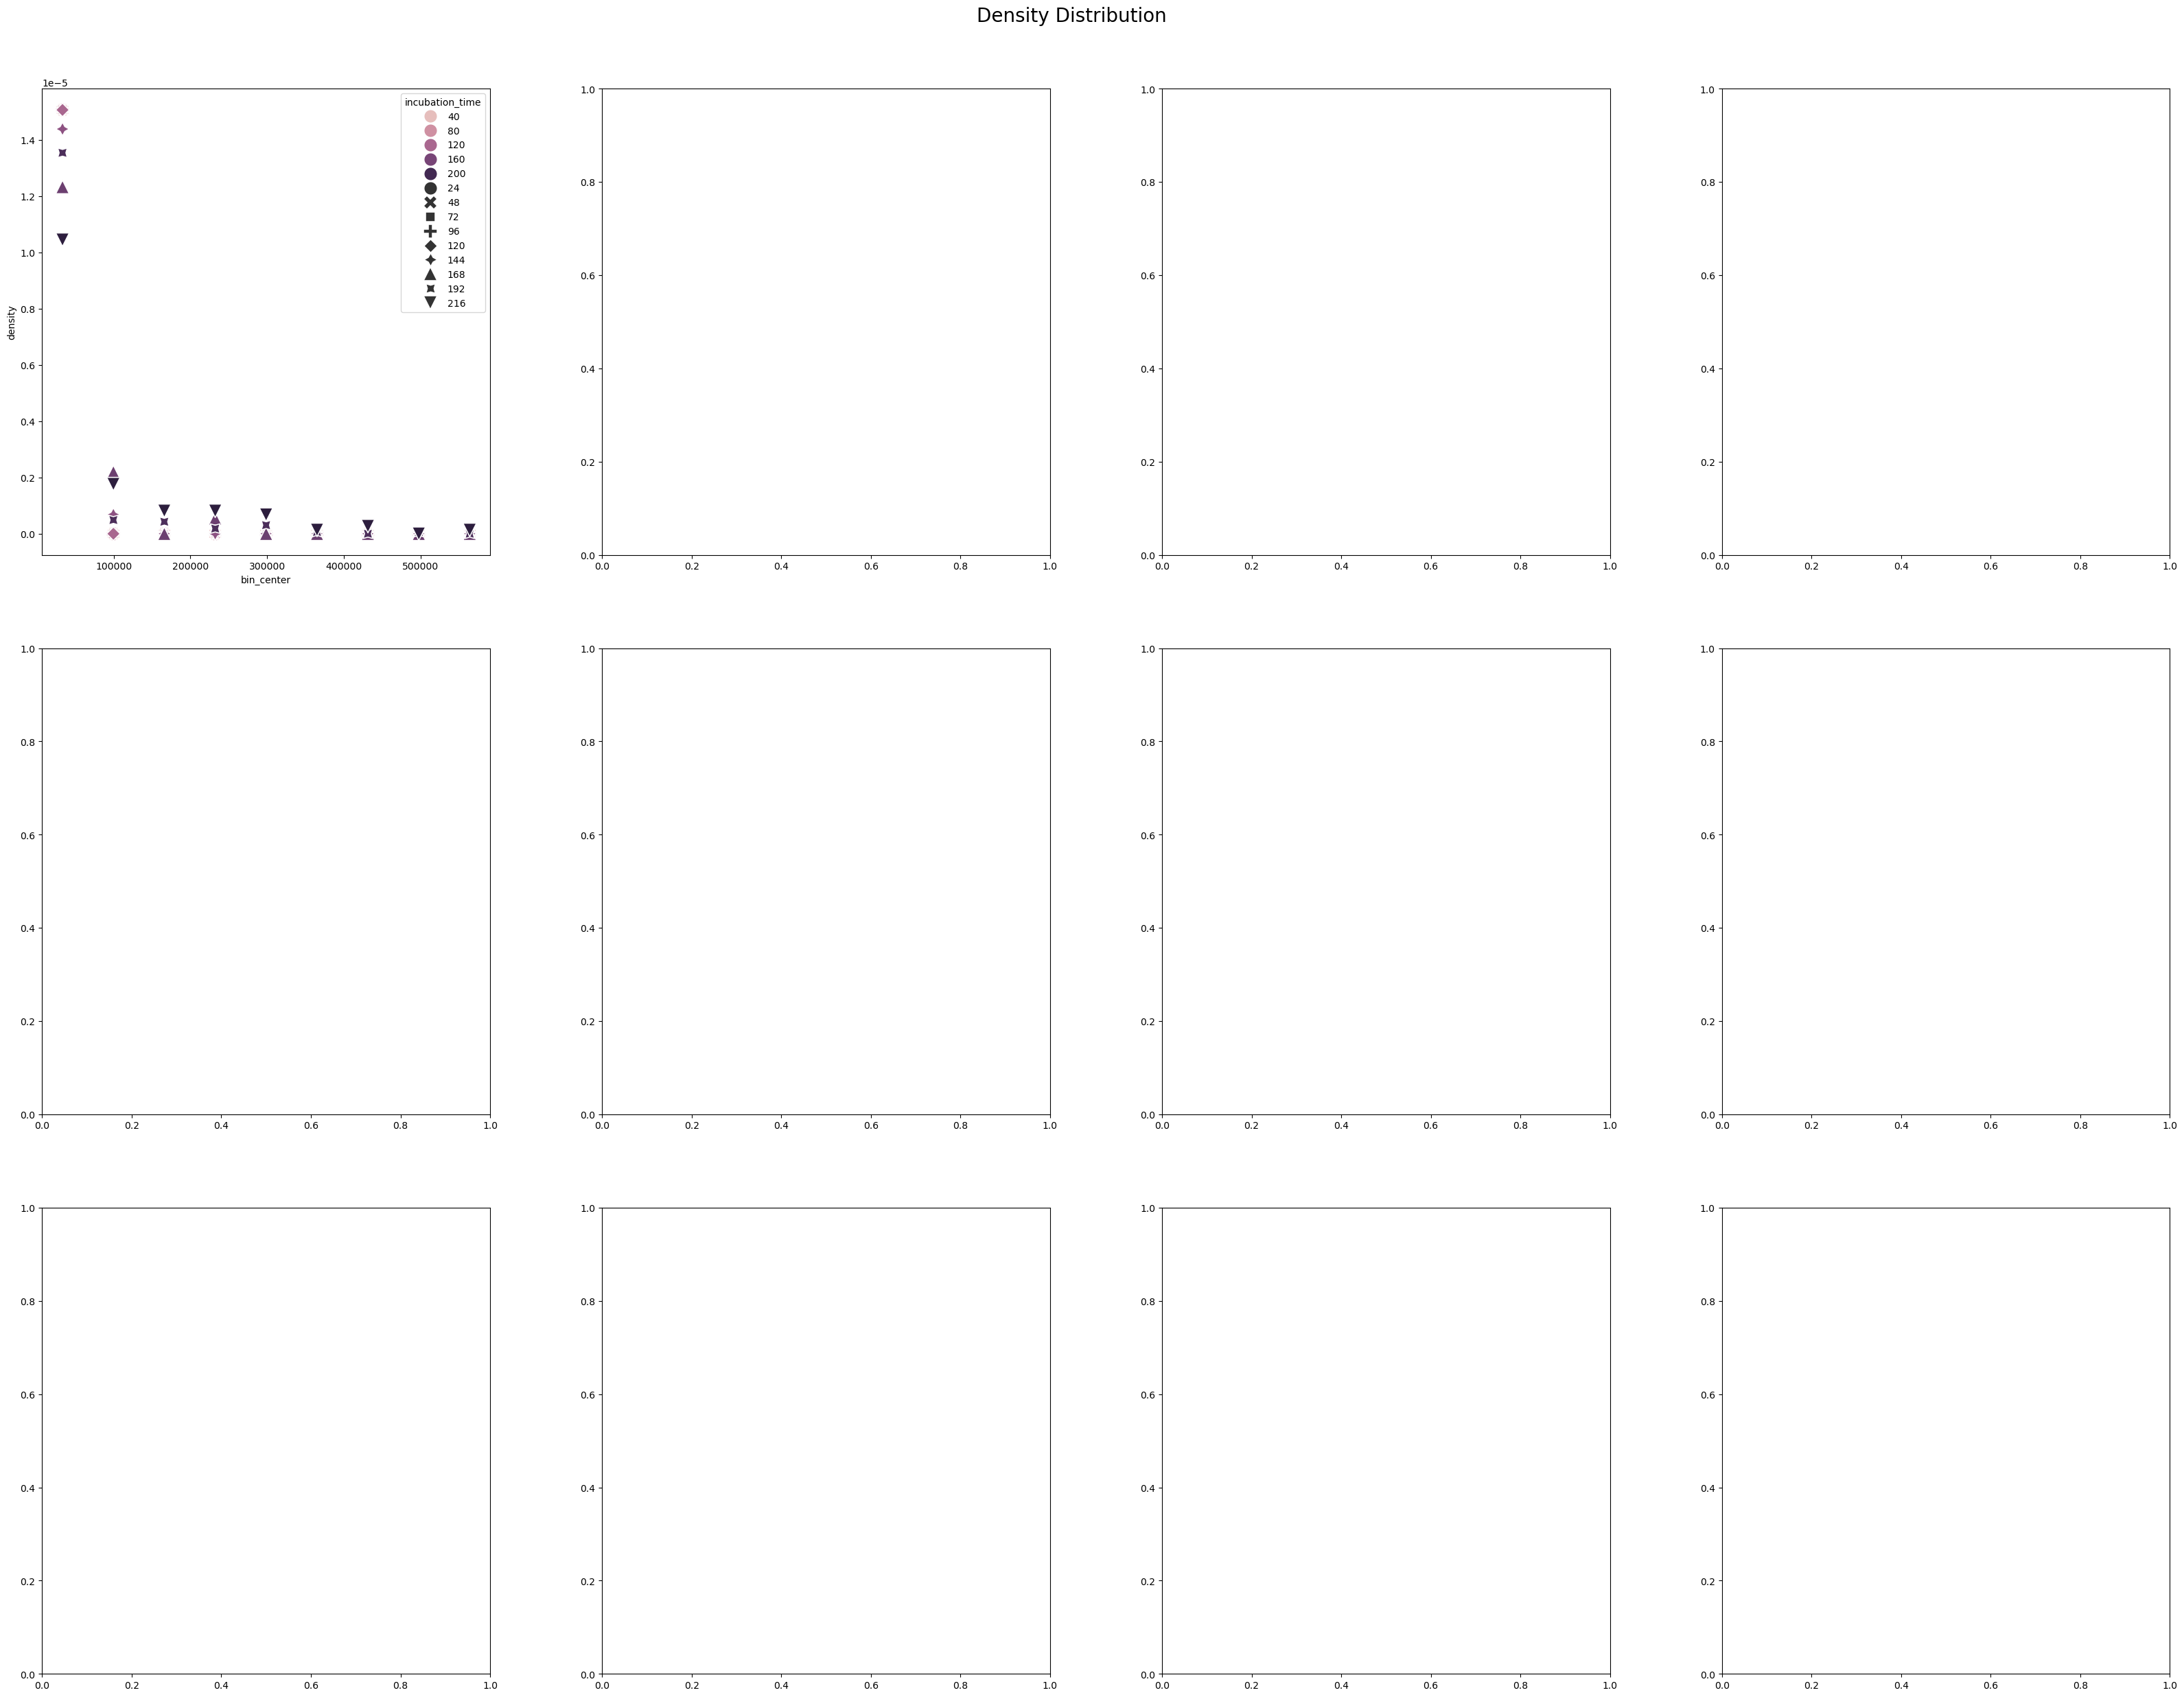

In [83]:

def power_law(x, a, b):
    return a * (x ** b)

def exponential(x, a, b):
    return a * np.exp(b * x)

fig, axs = plt.subplots(3, len(unique_materials), figsize=(40, 30))
plt.subplots_adjust(wspace=0.25, hspace=0.2)
fig.suptitle("Density Distribution", fontsize=20, y=0.92)

s = Exp1_N[(Exp1_N['area'] > 1000)]

for i, unique_material in enumerate(unique_materials):
    specific_data = s[s['material'] == unique_material]
    for j, unique_line in enumerate(unique_lines):
        ax = axs[j, i]
        specific_specific_data = specific_data[specific_data['cell_line'] == unique_line]
        
        # Define bin edges and calculate densities
        bin_edges = np.linspace(int(min(specific_specific_data['area_N'])), int(max(specific_specific_data['area'])), num=10)
        densities = specific_specific_data.groupby('incubation_time')['area'].apply(
            lambda x: np.histogram(x, bins=bin_edges, density=True)[0]
        )

        # Create DataFrame for plotting
        density_df = pd.DataFrame(densities.tolist(), index=densities.index).reset_index()
        density_df.columns = ['incubation_time'] + [f'density_{i}' for i in range(density_df.shape[1] - 1)]
        
        # Add bin centers for plotting
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        density_df = density_df.melt(id_vars='incubation_time', var_name='bin', value_name='density')
        density_df['bin'] = density_df['bin'].str.extract(r'(\d+)').astype(int)
        density_df['bin_center'] = bin_centers[density_df['bin']]
        
        # Plotting
        sns.scatterplot(data=density_df, x='bin_center', y='density', hue='incubation_time', style='incubation_time', s=200, ax=ax)

        # Fit and plot for each incubation time
        for incubation_time in density_df['incubation_time'].unique():
            subset = density_df[density_df['incubation_time'] == incubation_time]

            # Prepare x and y for fitting
            x_data = subset['bin_center'].values
            y_data = subset['density'].values

            # Fit power law
            popt_power, _ = curve_fit(power_law, x_data, y_data, p0=(1, -1), maxfev=50000)
            power_fit = power_law(x_data, *popt_power)

            # Fit exponential
            popt_exp, _ = curve_fit(exponential, x_data, y_data, p0=(1, 0.1), maxfev=50000)
            exp_fit = exponential(x_data, *popt_exp)

            # Calculate R² values
            r_squared_power = 1 - (np.sum((y_data - power_fit) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2))
            r_squared_exp = 1 - (np.sum((y_data - exp_fit) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2))

            # Choose the better fit
            if r_squared_power > r_squared_exp:
                best_fit = power_fit
                best_fit_label = 'Power Law'
                best_params = popt_power
            else:
                best_fit = exp_fit
                best_fit_label = 'Exponential'
                best_params = popt_exp

            # Plotting the best fit
            ax.plot(x_data, best_fit, label=f'Best Fit: {best_fit_label}', linewidth=2)
        # Set labels and title
        ax.set_xlabel("Size", fontsize=20)
        ax.set_ylabel("Cluster Size Distribution", fontsize=20)
        ax.set_title(f"{unique_line}, {unique_material}", fontsize=25)
        ax.legend()

        # Calculate Q1, Q3, and IQR for y-axis limit
        Q1 = density_df['density'].quantile(0.25)
        Q3 = density_df['density'].quantile(0.75)
        IQR = Q3 - Q1
        y_limit = Q3 + 1.5 * IQR
        #min_y_limit = max(0.01, y_limit)  # Ensure a minimum y-limit for log scale
        ax.set_yscale('log')
        ax.set_xscale('log')
        #ax.set_ylim(0.01, min_y_limit)  # Avoid log(0)

        # Set x-axis limits
        #x_min = density_df['bin_center'].quantile(0.05)
        #x_max = density_df['bin_center'].quantile(0.95)
        #x.set_xlim(x_min, x_max)

plt.show()


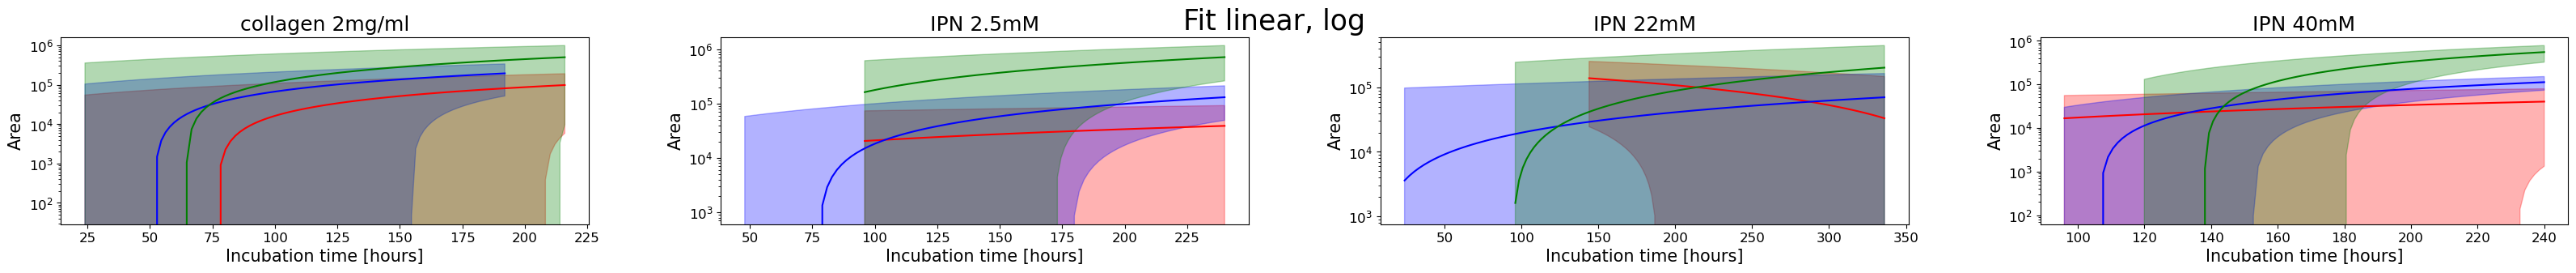

In [84]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(40, 3))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines,'Fit linear, log', polynomial_fit,'area')


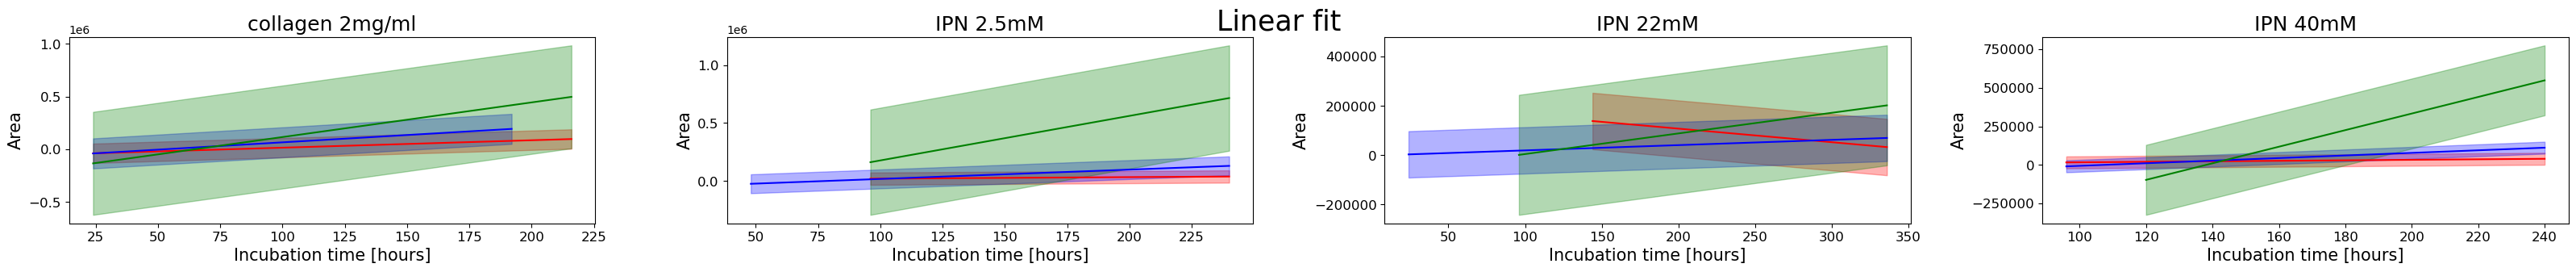

In [81]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(40, 3))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines,'Linear fit', polynomial_fit,'area')


In [77]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(40, 3))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Fit", fontsize=20, y=1.1)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines,'Gompertz pol', gompertz_fit)


c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\srboval1\AppData\Local\Temp\ipykernel_13980\3554219881.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(gompertz, data['incubation_time'], data['area'], p0=est_par)
C:\Users\srboval1\AppData\Local\Temp\ipykernel_13980\3554219881.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))


KDE plot - join distribution time-series

NameError: name 'df_plot' is not defined

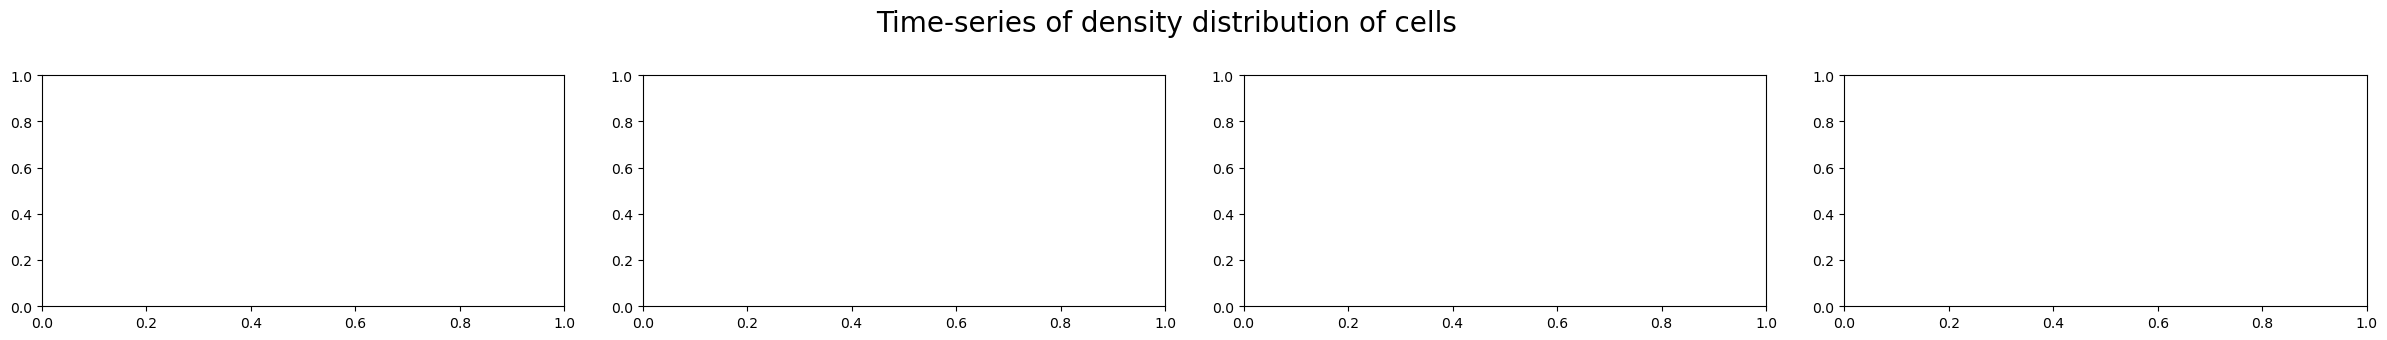

In [128]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Time-series of density distribution of cells", fontsize=20, y=1.1)


for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    ax=axs[i]

    sns.kdeplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax,bw_adjust=3, cut=0) #smoothened by adjusting bandwidth
    #legend=(i == len(unique_materials) - 1)
    ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
    ax.set_yscale('log')
    ax.set_ylabel('Density', fontsize= 15)  
    ax.set_title(f'{unique_material}', fontsize= 18)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(0.0001,0.01)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.get_legend().set_visible(False)

handles, labels = axs[-1].get_legend_handles_labels()
for line in specific_df_small['cell_line'].unique():
    handles.append(plt.Line2D([0], [0], color=(palette)[line], lw=3))
    labels.append(line)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)


# Make the legend visible for the last subplot




plt.savefig(path +'/results/Kernel_density_individual_cells.png',dpi=300)


Individual cells count barplots

Counts of distinct images for each condition

In [85]:
for i,unique_material in enumerate(unique_materials):
    for j,unique_line in enumerate(unique_lines):
            spec = Exp1_N[(Exp1_N['material'] == unique_material) & (Exp1_N['cell_line'] == unique_line) ]
            spec_times = spec['incubation_time'].unique()

            cell_line_counts = spec.groupby('incubation_time')['image_id'].nunique()
            cell_line_counts_df = cell_line_counts.reset_index()
            cell_line_counts_df.columns = ['incubation_time', 'unique_cell_line_count']

            #print(f"{unique_line}, {unique_material}, {cell_line_counts_df}")


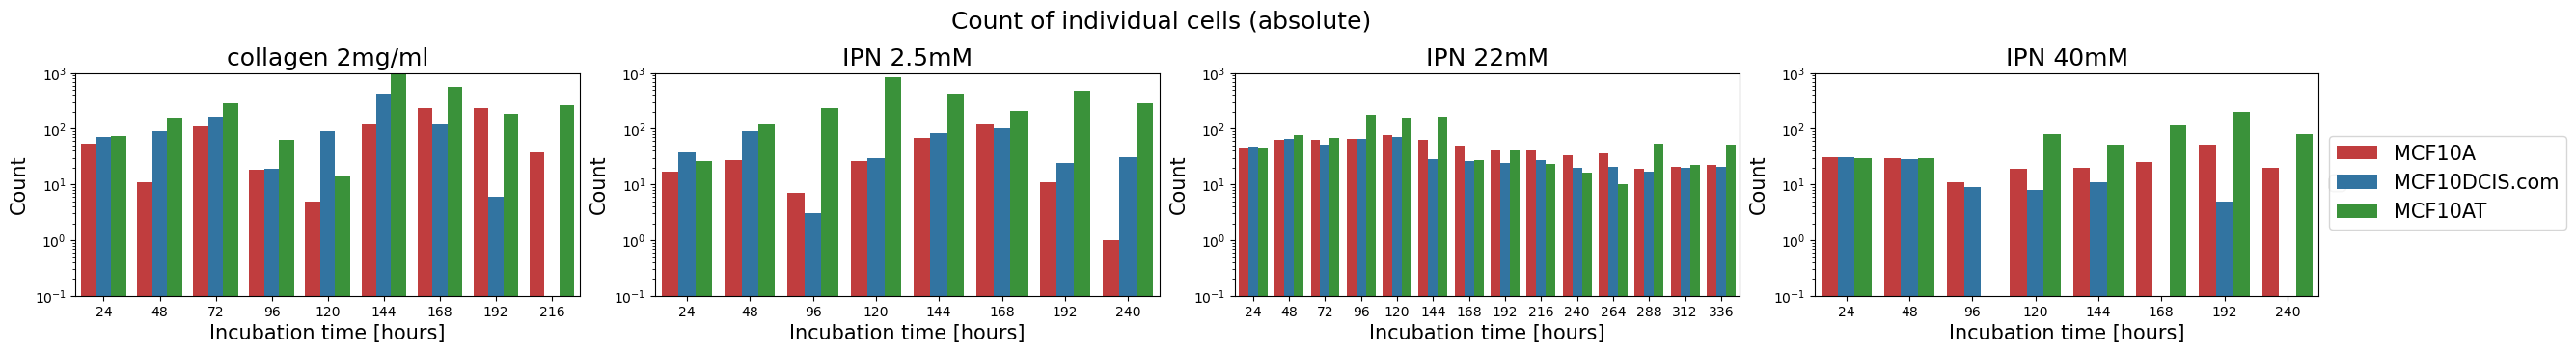

In [89]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Count of individual cells (absolute)", fontsize=18, y=1.1)
#fig.legend(loc=7)

for i,unique_material in enumerate(unique_materials):
    specific_df_small = Exp1_N[(Exp1_N['material'] == unique_material) & (Exp1_N['area'] < 10000) ]
    ax=axs[i]

    #mymodel = np.poly1d(np.polyfit(specific_specific_df_small['incubation_time'], specific_specific_df_small['area'], 1))
    #myline = np.linspace(specific_specific_df_small['incubation_time'].min(), specific_specific_df_small['incubation_time'].max(), 100)

    sns.countplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax) #smoothened by adjusting bandwidth

    ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
    ax.set_yscale('log')
    ax.set_ylabel('Count', fontsize= 15)  
    ax.set_title(f'{unique_material}', fontsize= 18)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(1e-1, 1000)  
    ax.get_legend().set_visible(False)


    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)

plt.savefig(path +'/results/Individual_cells_count_timeseries.png',dpi=300)


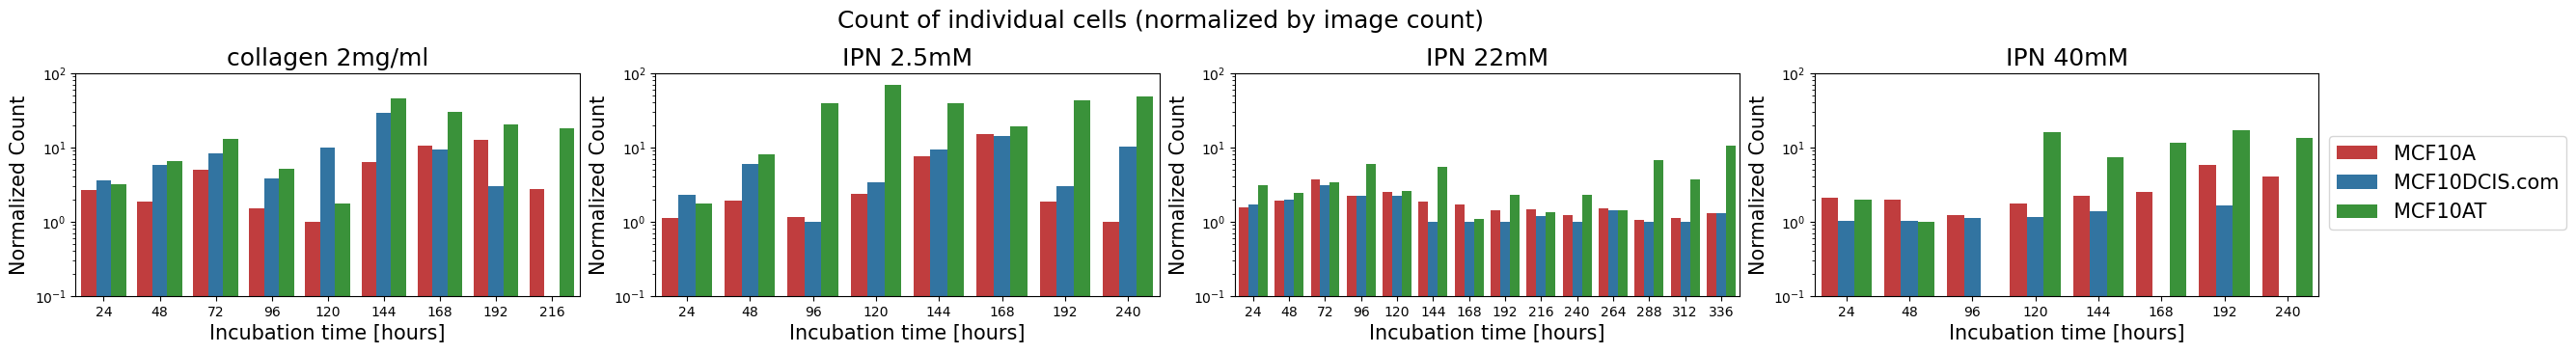

In [88]:

fig, axs = plt.subplots(1, len(unique_materials), figsize=(30, 3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Count of individual cells (normalized by image count)", fontsize=18, y=1.1)

for i, unique_material in enumerate(unique_materials):
    cells_df = Exp1_N[(Exp1_N['material'] == unique_material) & (Exp1_N['area'] < 10000)]

    # count of image IDs for each cell_line+incubation time
    img_count = cells_df.groupby(['cell_line', 'incubation_time'])['image_id'].nunique().reset_index()
    img_count.columns = ['cell_line', 'incubation_time', 'unique_image_count']

    # Count of cells
    count_data = cells_df.groupby(['cell_line', 'incubation_time']).size().reset_index(name='count')

    # Merge to get unique image counts
    cells_count = count_data.merge(img_count, on=['cell_line', 'incubation_time'])

    # Normalize the counts by the number of unique images
    cells_count['normalized_count'] = cells_count['count'] / cells_count['unique_image_count']

    ax = axs[i]

    # Use barplot for normalized values
    sns.barplot(data=cells_count, x='incubation_time', y='normalized_count', hue='cell_line', palette=palette, ax=ax,hue_order=labels)

    ax.set_xlabel('Incubation time [hours]', fontsize=15)
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_ylabel('Normalized Count', fontsize=15)
    ax.set_title(f'{unique_material}', fontsize=18)
    ax.set_ylim(1e-1, 100)  
    ax.get_legend().set_visible(False)

# Create a common legend
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)

plt.savefig(path + '/results/Individual_cells_count_timeseries_normalized.png', dpi=300)


Convexity of spheroids & fit

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1/plots/Convexity_time_series.png'

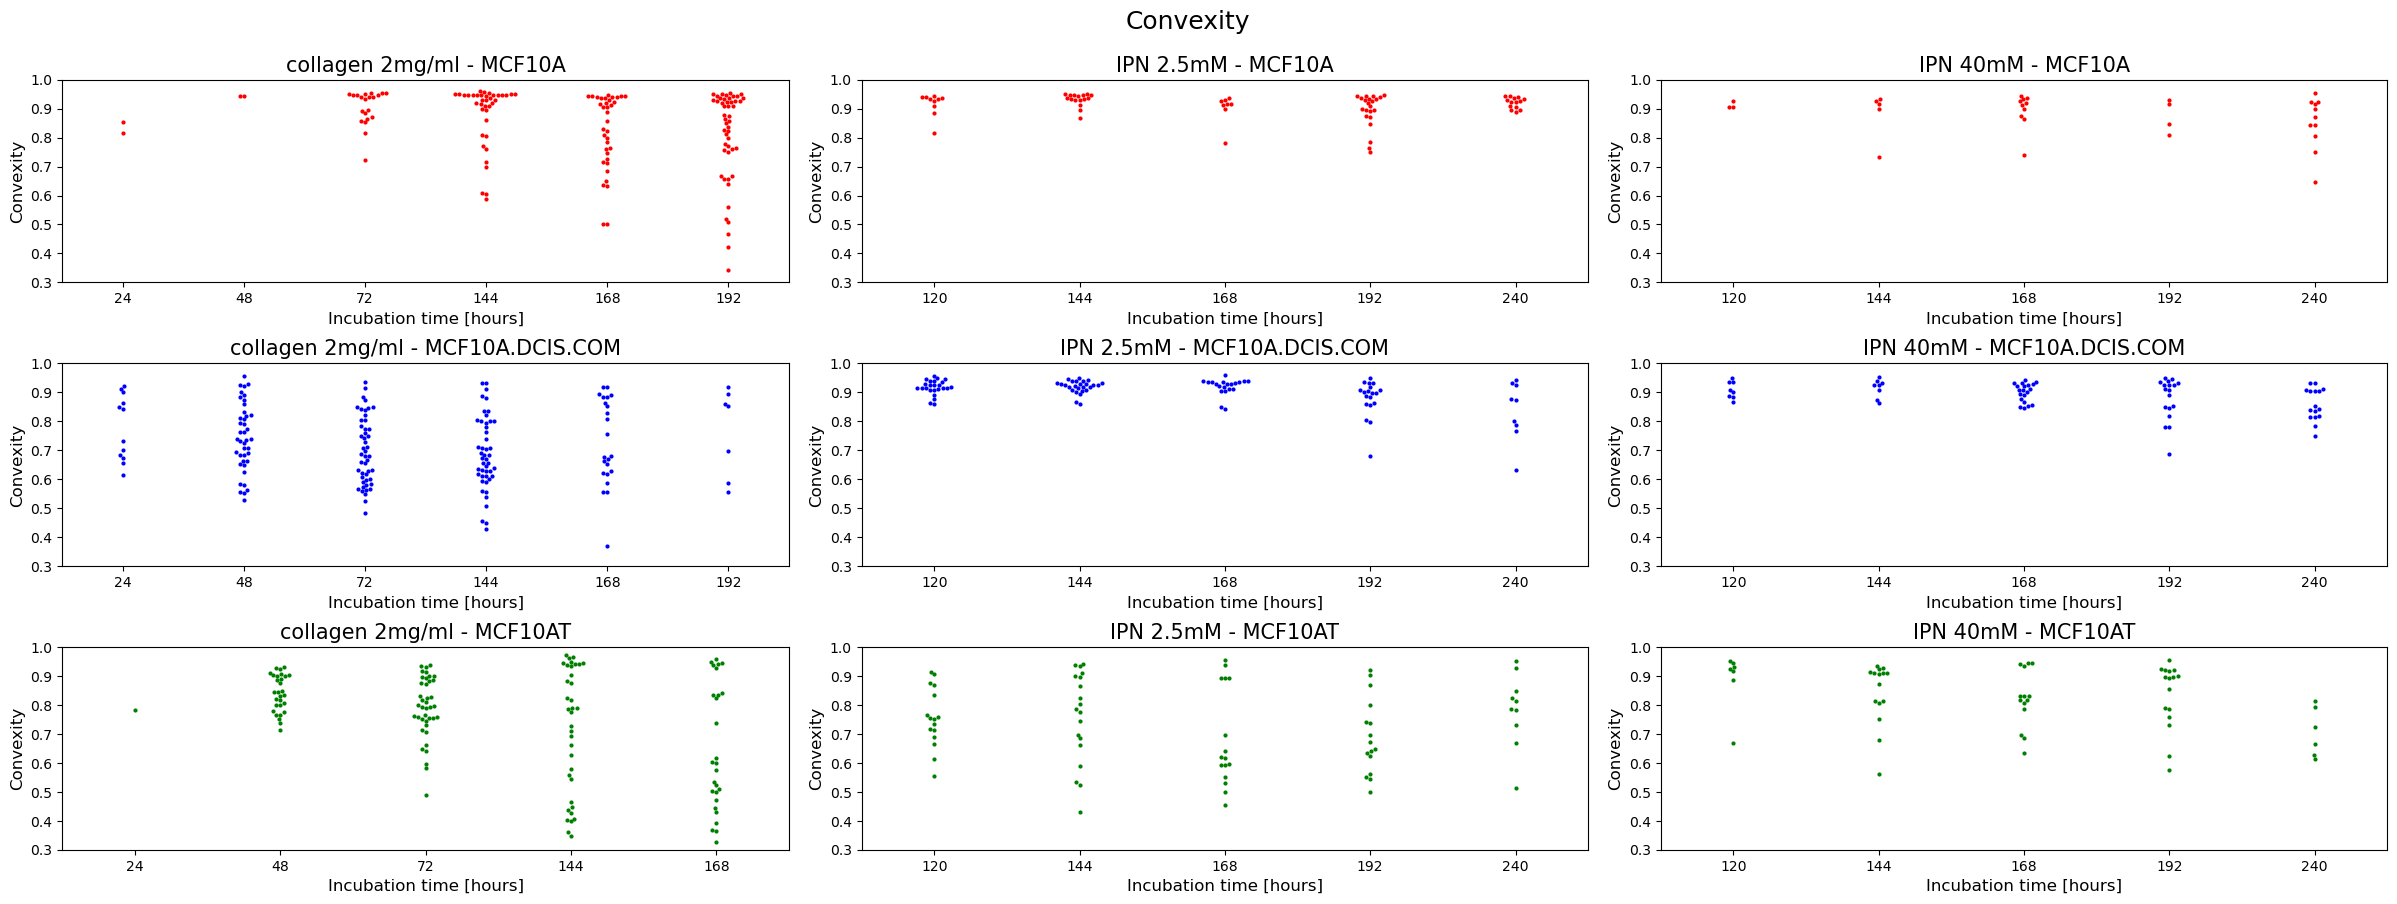

In [60]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.1, hspace=0.4)
fig.suptitle("Convexity", fontsize=18, y=0.95)
color=['red','blue','green']


for i,unique_material in enumerate(unique_materials):
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]
        ax=axs[j,i]

        sns.swarmplot(data=specific_specific_df_big, y='convexity_perimeter', x='incubation_time', size=3, color=color[j], ax=ax)

        ax.set_xlabel('Incubation time [hours]', fontsize= 12)  
        #ax.set_yscale('log')
        ax.set_ylabel('Convexity', fontsize= 12)  
        ax.set_title(f'{unique_material} - {unique_line}', fontsize= 15)
        ax.set_ylim(0.3,1)

plt.savefig(path +'/plots/Convexity_time_series.png',dpi=300)


fig, axs = plt.subplots(1,len(unique_materials),figsize=(30,3.3))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Fit of convexity", fontsize=18, y=1.05)

color=['red','blue','green']

for i,unique_material in enumerate(unique_materials):
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]

        #fitting model - determining weights 𝑏₀ and 𝑏₁
        mymodel = np.poly1d(np.polyfit(specific_specific_df_big['incubation_time'], specific_specific_df_big['convexity_perimeter'], 1))
        myline = np.linspace(specific_specific_df_big['incubation_time'].min(), specific_specific_df_big['incubation_time'].max(), 100)

        # Plot the polynomial fit
        # Plot the swarm plot
        ax=axs[i]
        ax.plot(myline, mymodel(myline), color= color[j])

        ax.set_xlabel('Incubation time [hours]', fontsize= 10)  
        #ax.set_yscale('log')
        #ax.set_ylabel('Convexity', fontsize= 12)  
        ax.set_title(f'{unique_material}', fontsize= 12)
        #ax.set_ylim(1000,10000000)
        ax.set_ylim(0.6,1)


plt.savefig(path +'/plots/Convexity_fit.png',dpi=300)


MCF10T: Segmented images & contour area

In [ ]:
csv_path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
df = pd.read_csv(path +'/out.csv', index_col=None)

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10AT\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10AT\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('MCF10AT 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('MCF10AT 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


10A

In [ ]:

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('MCF10A 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('MCF10A 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


DCIS.COM

In [ ]:
csv_path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
df = pd.read_csv(path +'/out.csv', index_col=None)

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A.DCIS.COM\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A.DCIS.COM\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('DCIS.COM 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('DCIS.COM 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


In [ ]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Time-series histograms", fontsize=18, y=1)

timestamp = 140

for i,unique_material in enumerate(unique_materials):
    specific_df = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 1500) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]
        ax=axs[j,i]
        sns.scatterplot(specific_specific_df, y='area', ax=ax, x='incubation_time')
        ax.set_yscale('log')
        ax.set_xlabel('Incubation')  
        ax.set_ylabel('Area')
        ax.set_title(f'{unique_material} - {unique_line}')
        ax.set_ylim(100,10000000)


In [ ]:
columns_to_plot=['cell_line','incubation_time','material','area_N','perimeter_N','roundness_N','aspect_ratio_N']
plot= final_df_with_normalized[columns_to_plot]

grouped_material = plot.groupby('material')

first_displayed = False
for name_material, material in grouped_material:
    #print(name_material)
    grouped_cell_line = material.groupby('cell_line')
    fig, ax = plt.subplots()
    
    for cell_line_name, line in grouped_cell_line:
        #print(cell_line_name)
        grouped = line.groupby('incubation_time').mean()
        #plt.plot(grouped['incubation_time'],grouped['area_N'],marker='o', linestyle='-', label=f'Group {cell_line_name}' )
        print(grouped)


In [ ]:
fig, ax = plt.subplots()
for name, group in grouped:
    ax.plot(group['area_N'], group['incubation_time'], marker='o', linestyle='-', label=f'Group {name}')


In [ ]:

grouped = plot.groupby(['material'])
grp = plot.groupby(['material', 'concentration','incubation_time'])

for (concentration), group in grouped:
    rows =  2
    columns = 7
    for (material,concentration, incubation_time), group in grp:
        for a in range(rows):
            for b in range(columns):
                    print(a,b)

In [ ]:

concentration_mapping1 = {
1:'2mgml',
2:'3mM',
3:'40mM'
}
material_mapping1 = {
1:'2mgml',
2:'3mM',
3:'40mM' 
}
materials_no = plot['material'].nunique()

#for (material, concentration), group1 in grp:
#   times = group1['incubation_time'].nunique()
for (concentration), group in grouped:
    rows_unique =  group['incubation_time'].nunique()
    for (material,concentration, incubation_time), group in grp:
        cols = 4
        rows = rows_unique
    # Calculate the number of rows needed
        fig, axes= plt.subplots(rows, cols,figsize=(15, 4), sharey=True)
        fig.suptitle(f'{concentration_mapping1.get(concentration)}, {incubation_time} hours', fontsize=16)
        for a in range(rows):
            for b in range(cols):
                for column in group.columns:
                    if column not in ['concentration','incubation_time', 'material','cell_line']:
                        sns.kdeplot(data=group[column],ax=axes[a,b], legend = False)
    #                    else:
    #                       sns.kdeplot(data=group[column],ax=axes[a,i+1], legend = False)
                    else:
                        continue

In [ ]:
for key, group in grouped_day:
    #plt.title("Incubation time" + str(key),loc='center')
    pairplot = sns.pairplot(group, kind='scatter', hue='cell_line', corner=True, vars=['material','concentration','area_N', 'perimeter_N', 'roundness_N','aspect_ratio_N'])
    pairplot.figure.suptitle(f'Incubation time: {key} hours, {concentration}', fontsize=20 )  # Adjust y position for title



